<a href="https://colab.research.google.com/github/Ausmints/home_credit/blob/main/Home_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the financial state of loan applicants using Home Credit data

Decision to lend your money to somebody else should never be taken without careful consideration. If it's a friend that you lend your money to, his inability to pay you back might ruin your friendship, or if you have a lending company, too many bad investments might lead to bankruptcy and you having to apply for a loan yourself. That doesn't mean that you shouldn't do it - either you just want to help somebody in a hard situation, or create a living out of it, but you should do it carefully. 

In this project we will create a model to help with these decisions - a model that predicts whether the person applying for the loan is likely to struggle with repaying their debt.

## Setting up the libraries

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "1NjAghvkSws_Ft6beHJBqfpNdTv_9DDgI"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("AUS_Functions.py")

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from AUS_Functions import *
import re
import joblib

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
    OneHotEncoder,
)

from sklearn.linear_model import LogisticRegression
import xgboost as xg

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.pipeline import Pipeline as imb_pipeline

In [ ]:
!pip install optuna
!pip install shap
import optuna
import shap

In [ ]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
}

## Figuring out the objectives

Before we can start doing anything else, we should define what are the objectives for our project. One of the largest problems with which lending companies are faced everyday is to decide whether the person applying for a loan is a safe enough investment and should they risk lending the money. There are other roblems, risks companies have to deal with, however this is the problem we're going to be adressing since the dataset seems to be appropriate for it.  

First we need to decide what our target features should be. A column showing which loans have defaulted would be the best option, columns showing whether the client has ever not paid in time would be my second pick. 

In [ ]:
id = "1LX4s2BB2cT3pGHGxpZPVPF5JR0mO3kY8"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("HomeCredit_columns_description.csv")
df_descriptions = pd.read_csv(
    "HomeCredit_columns_description.csv", encoding_errors="ignore", index_col="RowNum"
)

In [ ]:
df_descriptions.loc[2, "Description"]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'


Since the dataset had been originally compiled to be used in a competition, there actually is a "TARGET" column. However, if we take a closer look at the description of the feature, we can see that it seems to be tailored specifically for the competition and less useful in the real world cases. We can and will still use it as a proxy target - if our objective is to check whether a client has ever been late with payments for their loan, the "TARGET" feature contains at least a subset of them.

In [ ]:
df_descriptions.loc[174, "Description"]

'DPD (Days past due) during the month on the previous credit'

Two other features we could use are days past due features for both previous credit_card dataset and previous loans dataset. The problem with these two features is that since the dataset includes data of previous loans only for clients that have succesfully gotten a current loan, the data concerning previous loans might be biased and not contain as extreme cases as the data concerning current loans. Also, the datasets containing previous loan data have only a fraction of the features present for the current loans. There are some features from the current loan dataset we could safely use for the past loan prediction - for example gender, the education of the loan applicant, some others, however for most we can't safely deduce that the feature hasn't changed since the previous loan. 

After taking a look at the days-past-due features, I noticed that the correlations between the target and the available features were quite bad - most of the features that seem to be important for the TARGET feature in the current loan dataset can't be used for the past loans. So I decided that, even though it has it's limitations, taking the TARGET feature as our target is the best way to proceed.

As for our plan of approach - first we will explore and create a model using the dataset containing only current loan data. Then, we'll look at the other datasets and what data they contain could be used to further improve the performance of our model. Finally, we'll train the model again using all of the available data.

## EDA

First, let's take a look at the dataset containing current loan data.

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

In [ ]:
id = "1ygFTmFkcu8mqtz7Bu7CHF_vst48Zo72G"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("application_train.csv")
df = pd.read_csv("application_train.csv")

In [ ]:
df.head(18)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to age
dtypes: float64(67), int64(40), object(16)
memory usage: 288.6+ MB


We have 300 thousand entries with more than a hundred features.

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(10)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
dtype: float64

There are several features with quite high missing value counts, however the numbers are not so high that we should think about just dropping the feature.

In [ ]:
top_value_percentage = (
    df.apply(lambda x: x.value_counts().max(), axis=0) * 100 / df.shape[0]
)
top_value_percentage[top_value_percentage > 90].sort_values(ascending=False)

FLAG_MOBIL                     99.999675
FLAG_DOCUMENT_12               99.999350
FLAG_DOCUMENT_10               99.997724
FLAG_DOCUMENT_2                99.995773
FLAG_DOCUMENT_4                99.991870
FLAG_DOCUMENT_7                99.980814
FLAG_DOCUMENT_17               99.973334
FLAG_DOCUMENT_21               99.966505
FLAG_DOCUMENT_20               99.949270
FLAG_DOCUMENT_19               99.940490
FLAG_DOCUMENT_15               99.879029
FLAG_CONT_MOBILE               99.813340
FLAG_DOCUMENT_14               99.706352
FLAG_DOCUMENT_13               99.647492
FLAG_DOCUMENT_9                99.610420
FLAG_DOCUMENT_11               99.608794
FLAG_DOCUMENT_18               99.187021
FLAG_DOCUMENT_16               99.007190
FLAG_DOCUMENT_5                98.488509
REG_REGION_NOT_LIVE_REGION     98.485583
LIVE_REGION_NOT_WORK_REGION    95.934129
REG_REGION_NOT_WORK_REGION     94.923108
FLAG_EMAIL                     94.328008
REG_CITY_NOT_LIVE_CITY         92.182719
TARGET          

In [ ]:
df["FLAG_DOCUMENT_14"].value_counts()

0    306608
1       903
Name: FLAG_DOCUMENT_14, dtype: int64

In [ ]:
df = df.drop(top_value_percentage[top_value_percentage > 99.8].index, axis=1)

There are a lot of features containing almost exclusively just one value. We will drop all of the features that have less than 0.2 % of other values.

Let's test some hypothesis about data next!

In [ ]:
import statsmodels.api as sm

*Considering applicants that have and those that haven't had payment difficulties, does the annual income differ substantially between the two groups?*

**Null hypothesis**: The annual income is the same for both applicants that have had payment difficulties and those that hadn't.

**Alternative hypothesis**: The customers that haven't had payment difficulties have a larger mean annual income than those who had.

The sample size is big enough that we don't need to worry about normalty of our data.

In [ ]:
target_true = df.loc[df["TARGET"] == 1, "AMT_INCOME_TOTAL"]
target_false = df.loc[df["TARGET"] == 0, "AMT_INCOME_TOTAL"]
sm.stats.CompareMeans.from_data(target_true, target_false).ztest_ind(
    usevar="unequal", alternative="smaller"
)

(-0.7306653940270083, 0.2324917790452259)

There seem to be some correlation between "TARGET" and "AMT_INCOME_TOTAL", however the p-value is not small enough to reject null hypothesis.

*Considering applicants that have and those that haven't had payment difficulties, does the applicant age differ substantially between the two groups?*

**Null hypothesis**: The mean age is the same for both applicants that have had payment difficulties and those that hadn't.

**Alternative hypothesis**: The customers that haven't had payment difficulties have are in mean older than those who had.

The sample size is big enough that we don't need to worry about normalty of our data.

In [ ]:
df["age"] = (df["DAYS_BIRTH"] / -365).round()
df = df.drop("DAYS_BIRTH", axis=1)

In [ ]:
target_true = df.loc[df["TARGET"] == 1, "age"]
target_false = df.loc[df["TARGET"] == 0, "age"]
sm.stats.CompareMeans.from_data(target_true, target_false).ztest_ind(
    usevar="unequal", alternative="smaller"
)

(-45.01595733040308, 0.0)

The p-value is miniscule - age could be an important feature for predicting TARGET column.

Let's take a closer look at some of the features. Since there are a lot of features in total, I will only show those that seem important and have a visible correlation with the TARGET feature.

In [ ]:
df[df.columns[df.dtypes == "object"]].nunique().sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [ ]:
df.index.name = "index"

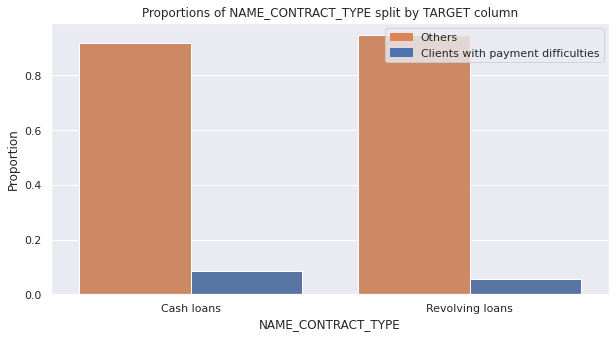

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "NAME_CONTRACT_TYPE",
    [],
    [
        "Proportions of NAME_CONTRACT_TYPE split by TARGET column",
        "NAME_CONTRACT_TYPE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=False,
    mode="proportion",
)

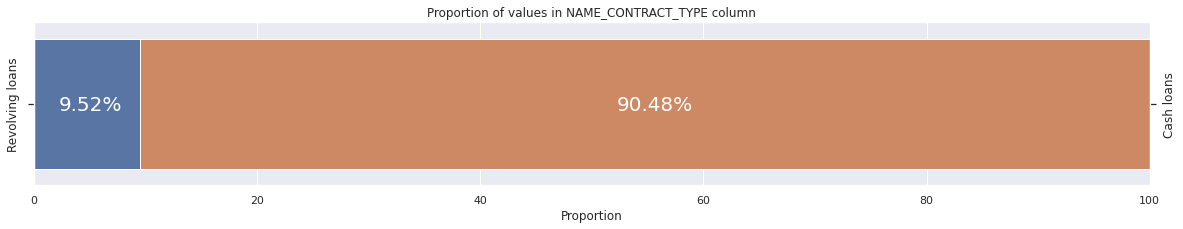

In [ ]:
draw_proportion_barplot(
    df["NAME_CONTRACT_TYPE"].value_counts(),
    ["Proportion of values in NAME_CONTRACT_TYPE column", "Proportion", "", ""],
)

People taking revolving loans seem to be less likely to have payment difficulties. However, only around 10% of the current loans are revolving loans.

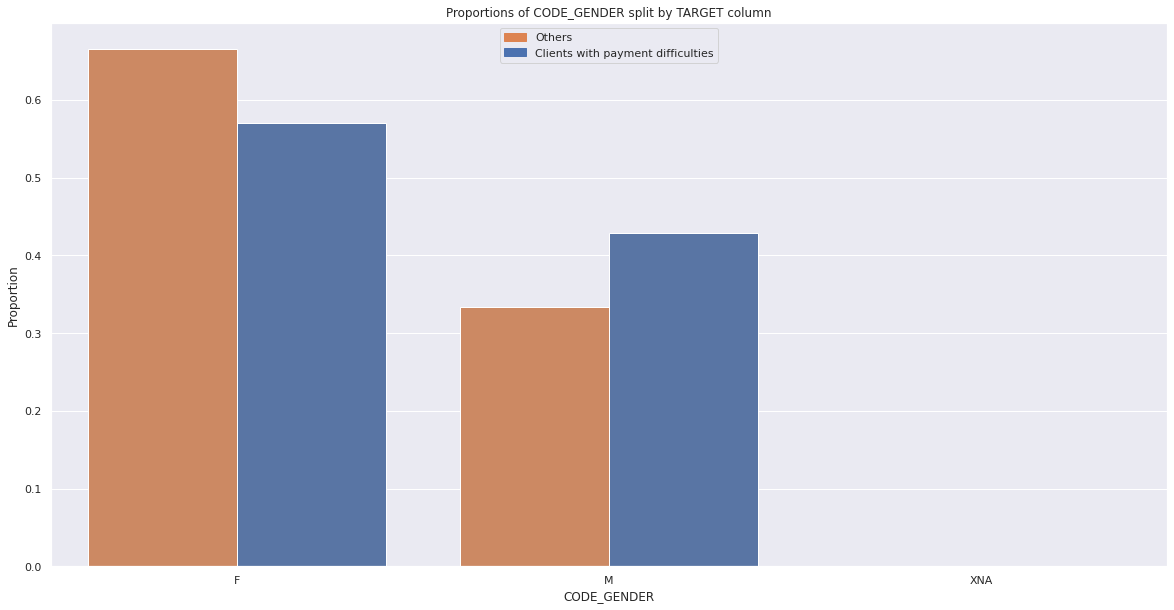

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "CODE_GENDER",
    [],
    [
        "Proportions of CODE_GENDER split by TARGET column",
        "CODE_GENDER",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

There are more female applicants than male, they are also less likely to have payment difficulties. There seem to be some missing data for the feature.

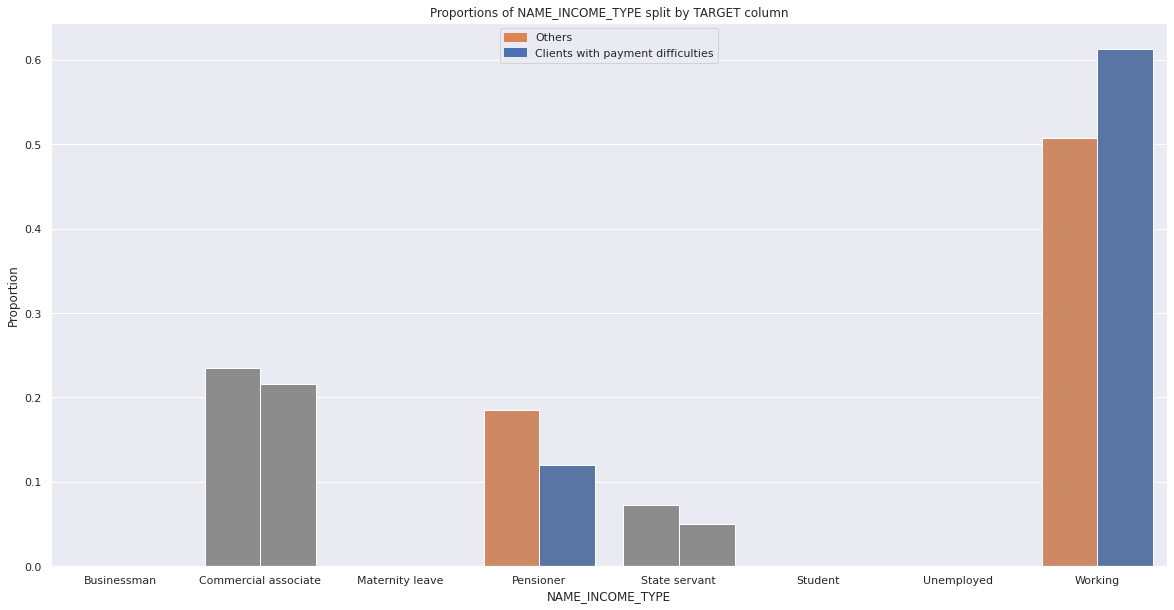

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "NAME_INCOME_TYPE",
    ["Working", "Pensioner"],
    [
        "Proportions of NAME_INCOME_TYPE split by TARGET column",
        "NAME_INCOME_TYPE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

Pensioners seem to be more financially reliable than working people.

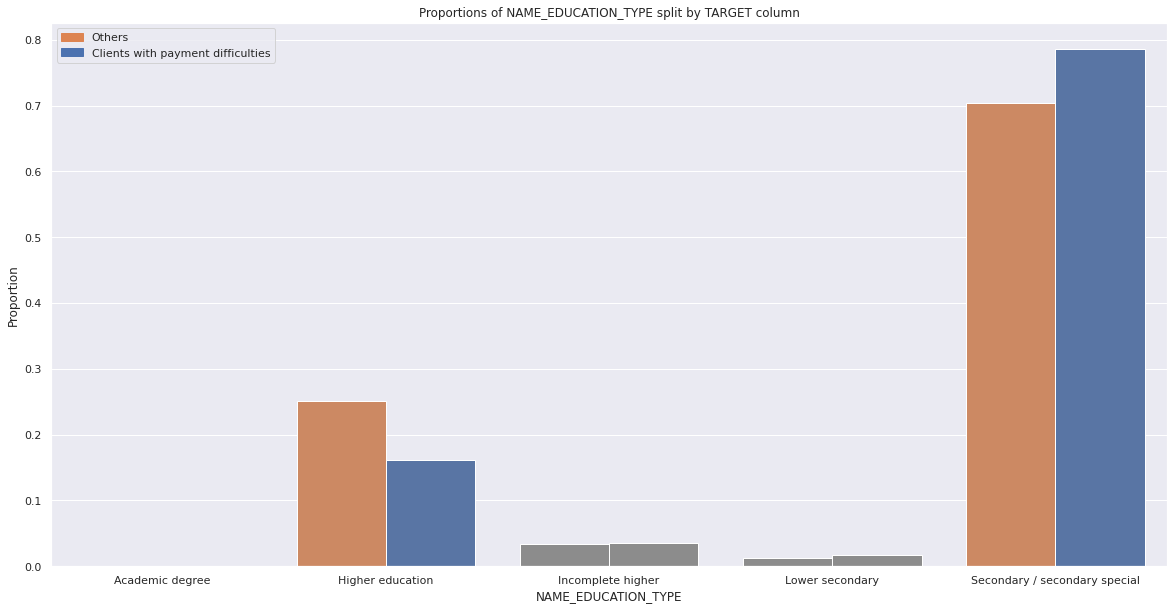

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "NAME_EDUCATION_TYPE",
    ["Higher education", "Secondary / secondary special"],
    [
        "Proportions of NAME_EDUCATION_TYPE split by TARGET column",
        "NAME_EDUCATION_TYPE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

Education seems to be positively correlated with financial stability - the higher the applicators education, the lower the possibility of the applicator having financial difficulties.

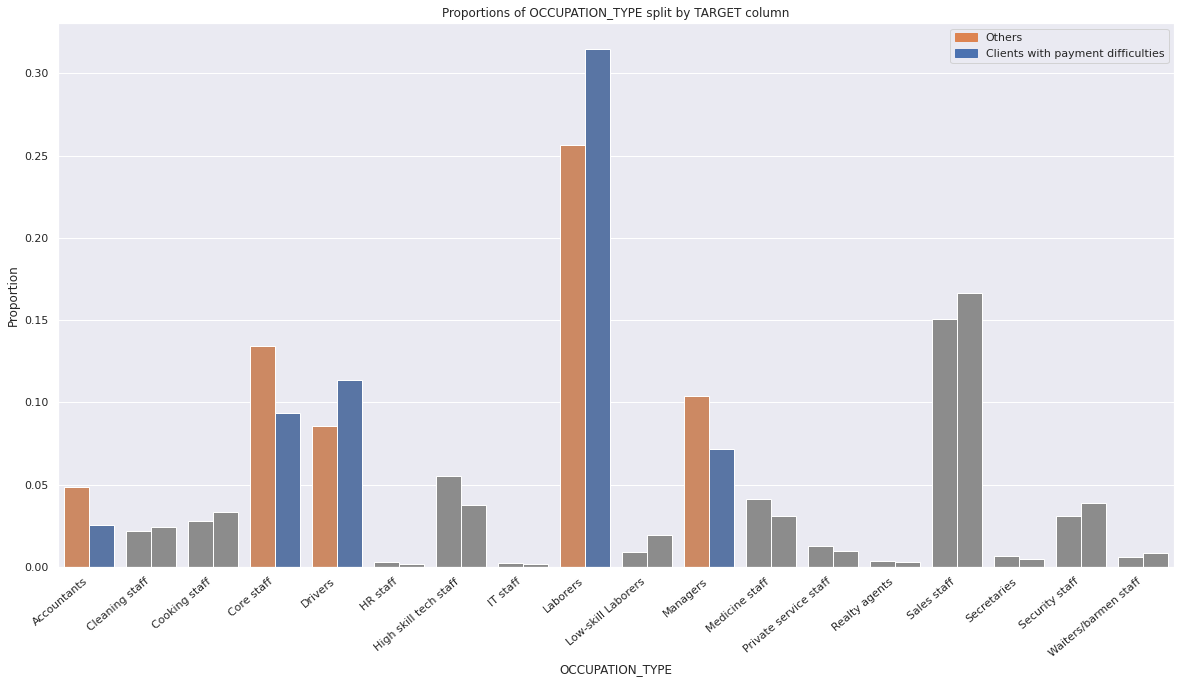

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "OCCUPATION_TYPE",
    ["Laborers", "Core staff", "Managers", "Accountants", "Drivers"],
    [
        "Proportions of OCCUPATION_TYPE split by TARGET column",
        "OCCUPATION_TYPE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

Type of carrer the applicator has also seem to play a significant role in whether the applicant will have difficulties in repaying debt. 

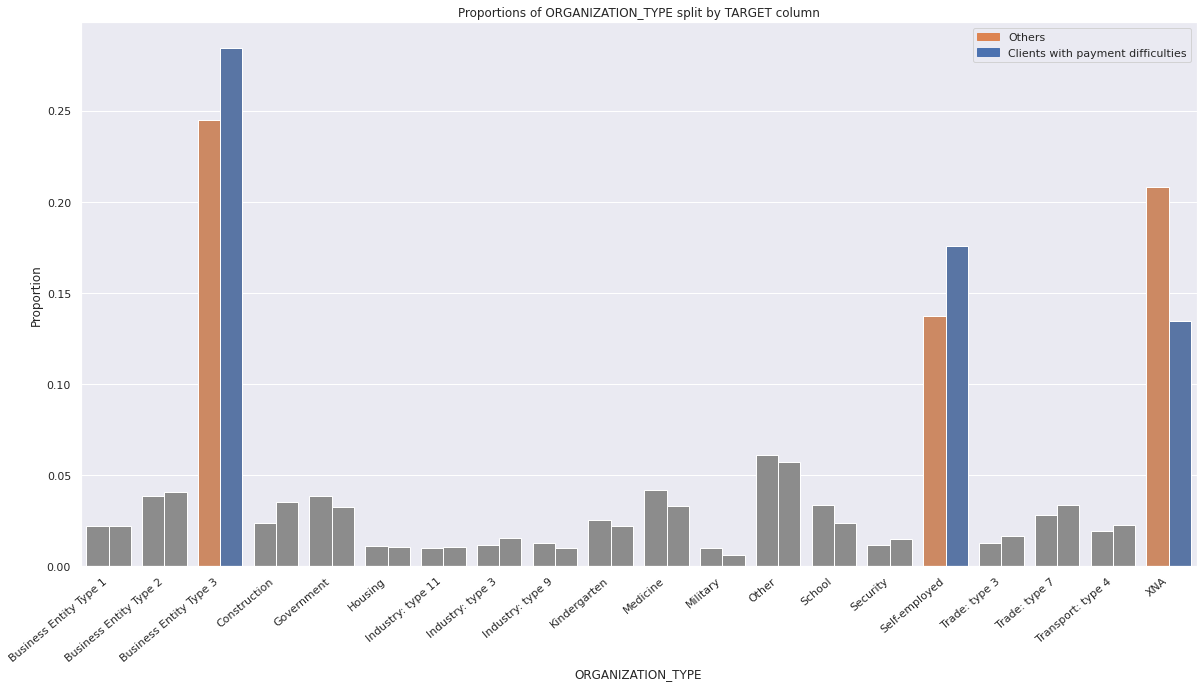

In [ ]:
draw_comparison_barplot(
    df[
        df["ORGANIZATION_TYPE"].isin(
            df["ORGANIZATION_TYPE"].value_counts().head(20).index
        )
    ],
    "TARGET",
    "ORGANIZATION_TYPE",
    ["Business Entity Type 3", "Self-employed", "XNA"],
    [
        "Proportions of ORGANIZATION_TYPE split by TARGET column",
        "ORGANIZATION_TYPE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

For most of the values in ORGANIZATION_TYPE feature the difference in proportions seem to be minimal. Exceptions are "Business Entity Type 3" and "Self-employed". Interesting to notice that there also seem to be a large difference in proportions for missing data.

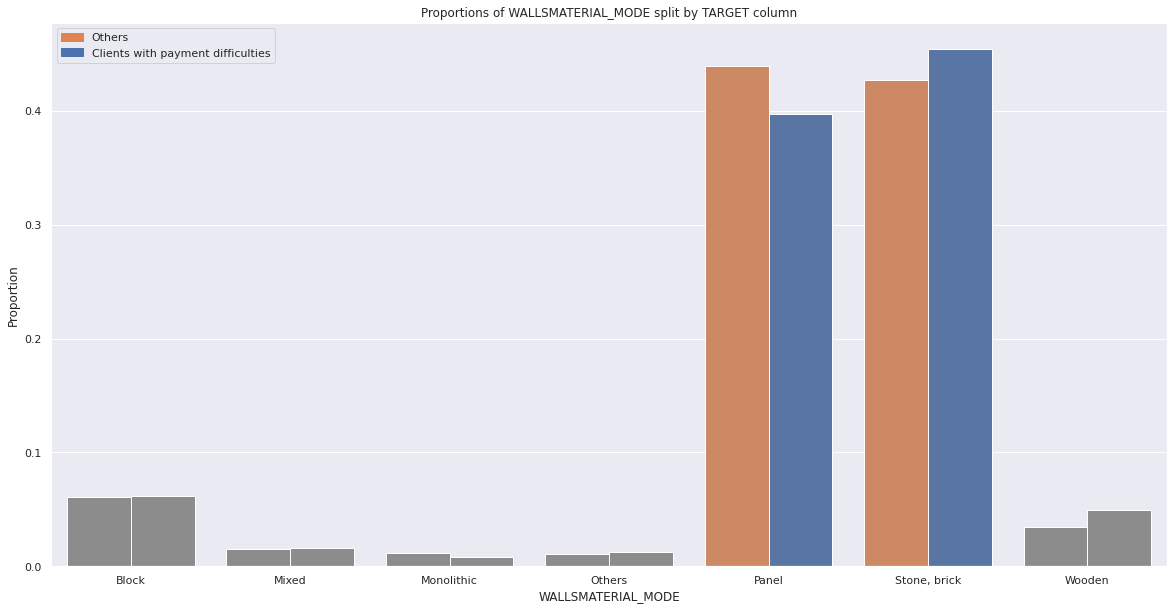

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "WALLSMATERIAL_MODE",
    ["Panel", "Stone, brick"],
    [
        "Proportions of WALLSMATERIAL_MODE split by TARGET column",
        "WALLSMATERIAL_MODE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

Unexpectedly the material of the walls in applicants residence also seem to be correlated with them having payment difficulties.

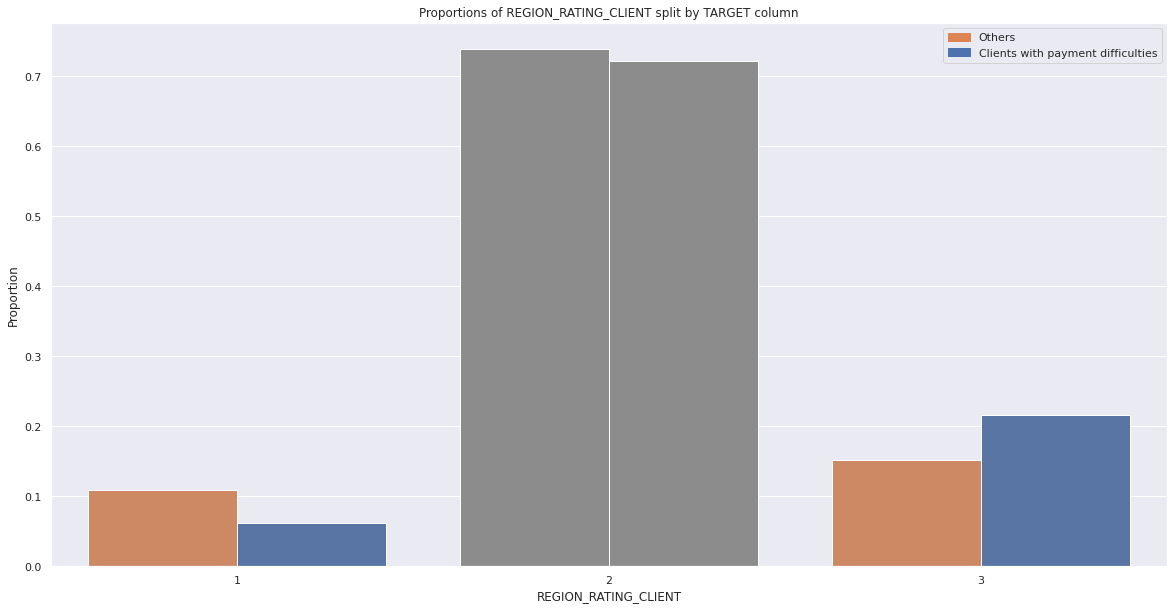

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "REGION_RATING_CLIENT",
    [1, 3],
    [
        "Proportions of REGION_RATING_CLIENT split by TARGET column",
        "REGION_RATING_CLIENT",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

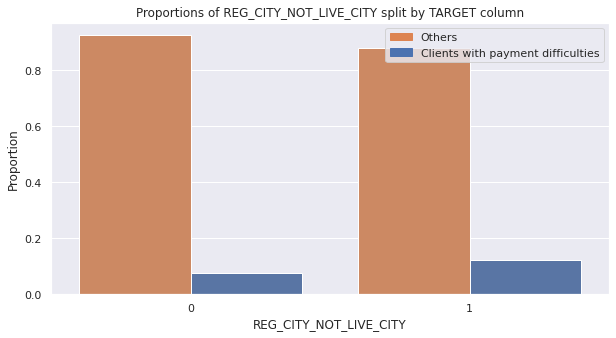

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "REG_CITY_NOT_LIVE_CITY",
    [0, 1],
    [
        "Proportions of REG_CITY_NOT_LIVE_CITY split by TARGET column",
        "REG_CITY_NOT_LIVE_CITY",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=False,
    mode="proportion",
)

Region where the applicant lives and also whether the city where they work is the same as the one where they live seem to be related with them having payment difficulties.

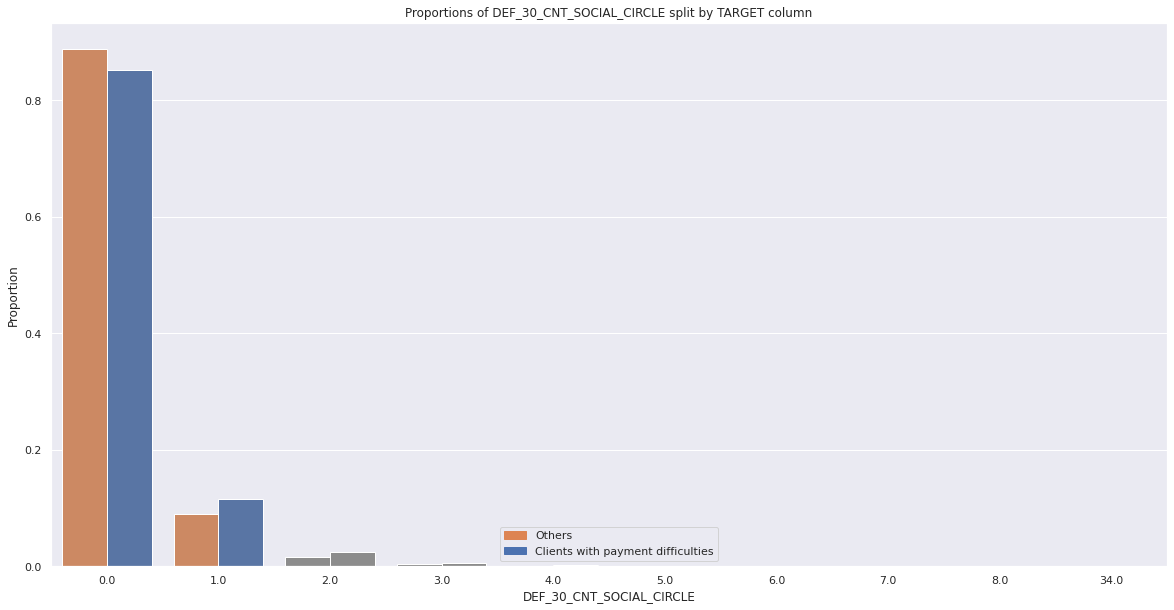

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    [0, 1],
    [
        "Proportions of DEF_30_CNT_SOCIAL_CIRCLE split by TARGET column",
        "DEF_30_CNT_SOCIAL_CIRCLE",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

Having people with payment difficulties in the applicants social circle seem to be correlated with applicant also having payment difficulties, albeit less important than I would have expected.

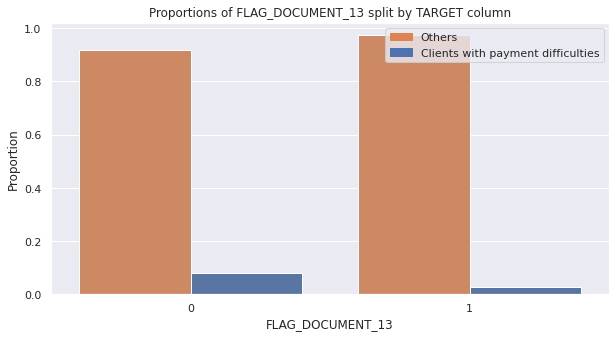

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "FLAG_DOCUMENT_13",
    [],
    [
        "Proportions of FLAG_DOCUMENT_13 split by TARGET column",
        "FLAG_DOCUMENT_13",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=False,
    mode="proportion",
)

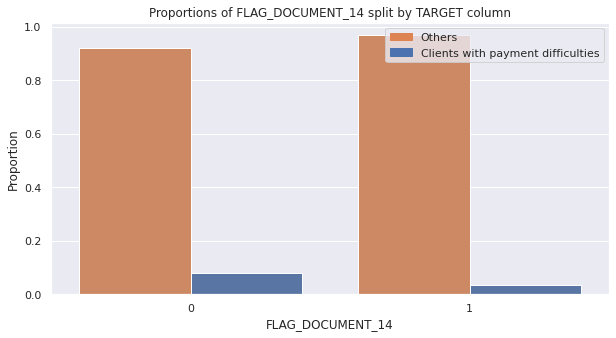

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "FLAG_DOCUMENT_14",
    [],
    [
        "Proportions of FLAG_DOCUMENT_14 split by TARGET column",
        "FLAG_DOCUMENT_14",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=False,
    mode="proportion",
)

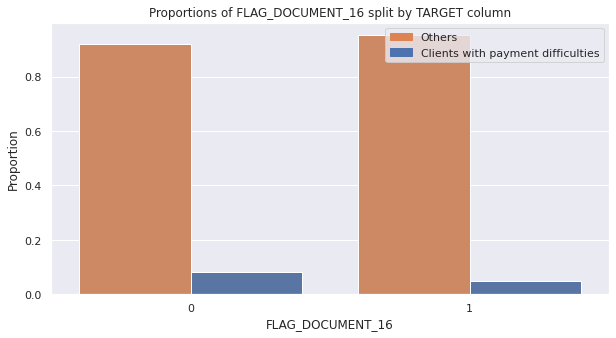

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "FLAG_DOCUMENT_16",
    [],
    [
        "Proportions of FLAG_DOCUMENT_16 split by TARGET column",
        "FLAG_DOCUMENT_16",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=False,
    mode="proportion",
)

There are several features describing whether the applicant has also included specific documents in their applications. As we can see, some of them seem quite relevant to predicting TARGET feature. Sadly, for most of them the variability is extremely low, so the features might not be as useful as they seem. 

Let's take a look at some of the numerical columns!

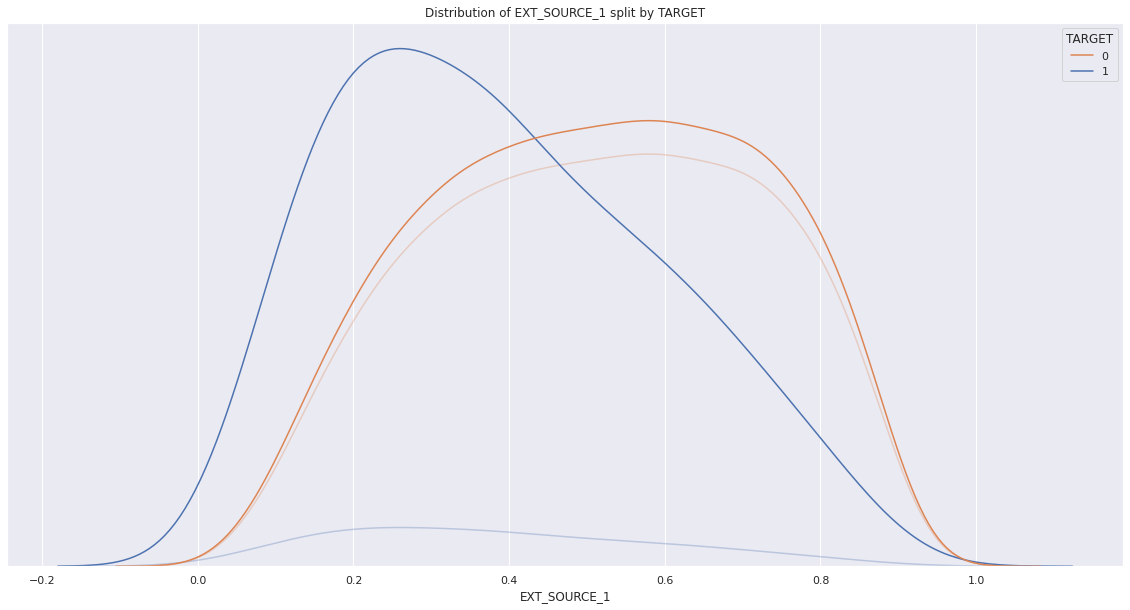

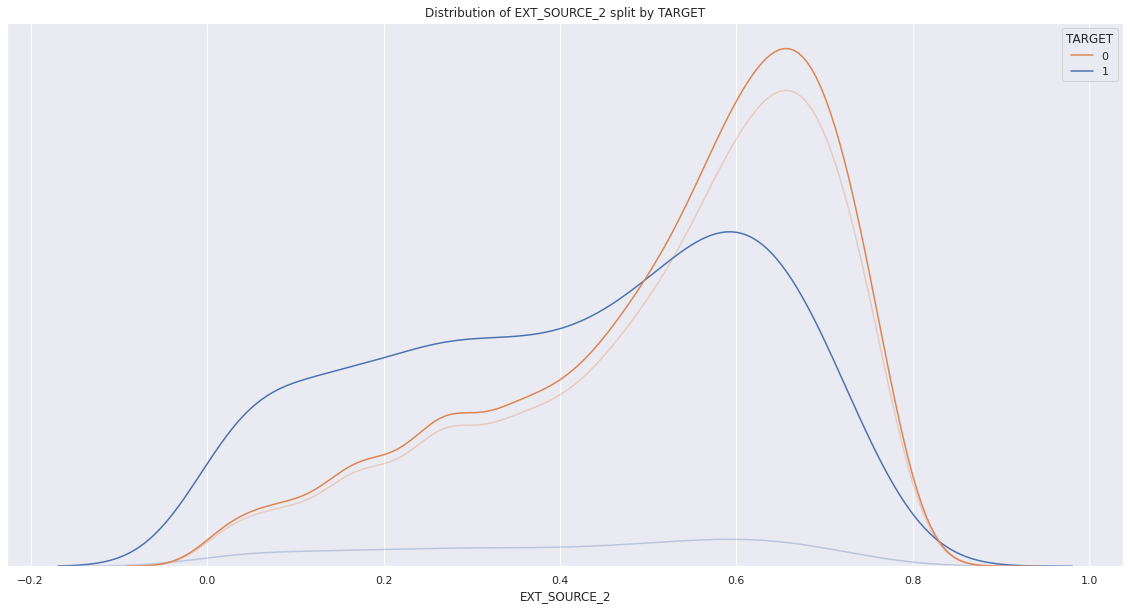

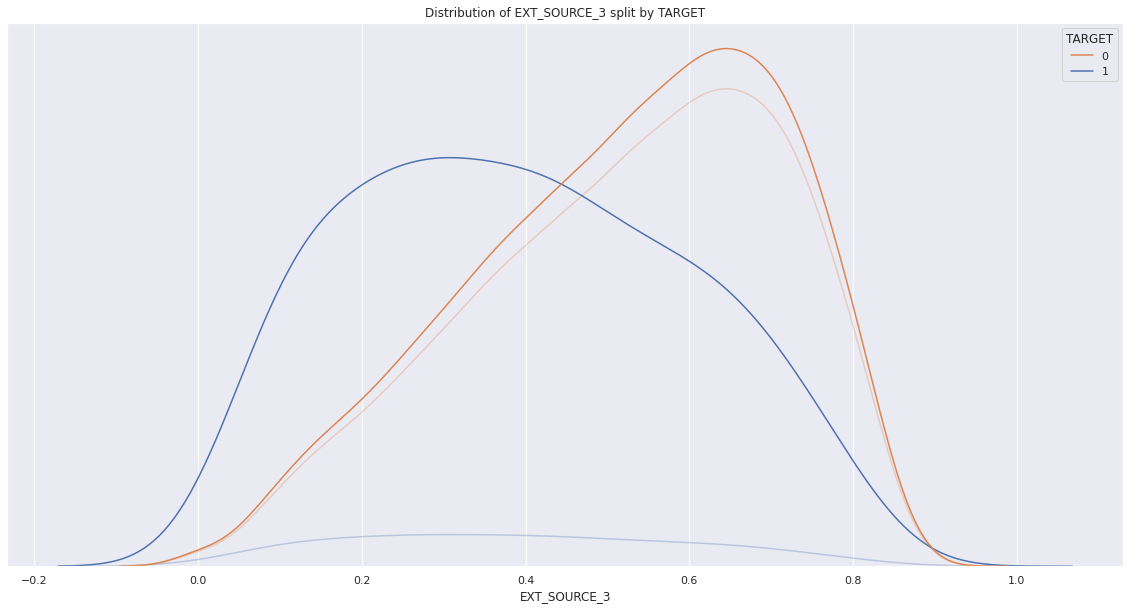

In [ ]:
for column in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]:
    plt.figure(figsize=(20, 10))
    ax = sns.kdeplot(
        data=df[df["AMT_INCOME_TOTAL"] < 1170000],
        x=column,
        hue="TARGET",
        palette=[colors["orange"], colors["blue"]],
        bw_adjust=2,
        alpha=0.3,
    )
    ax = sns.kdeplot(
        data=df[df["AMT_INCOME_TOTAL"] < 1170000],
        x=column,
        hue="TARGET",
        palette=[colors["orange"], colors["blue"]],
        bw_adjust=2,
        common_norm=False,
    )
    ax.set(xlabel=column, ylabel="")
    ax.set_title(f"Distribution of {column} split by TARGET")
    ax.set_yticks([])
    plt.show()

Unsuprisingly, applicant risk_scores, in the dataset given as EXT_SOURCE_1, 2 and 3, are closely related with them being able to repay their loan. The risk scores are given by three different companies using different calculation algorithms, thus the scores are different. Seems like the first and third seperate the TARGET values better than the second.

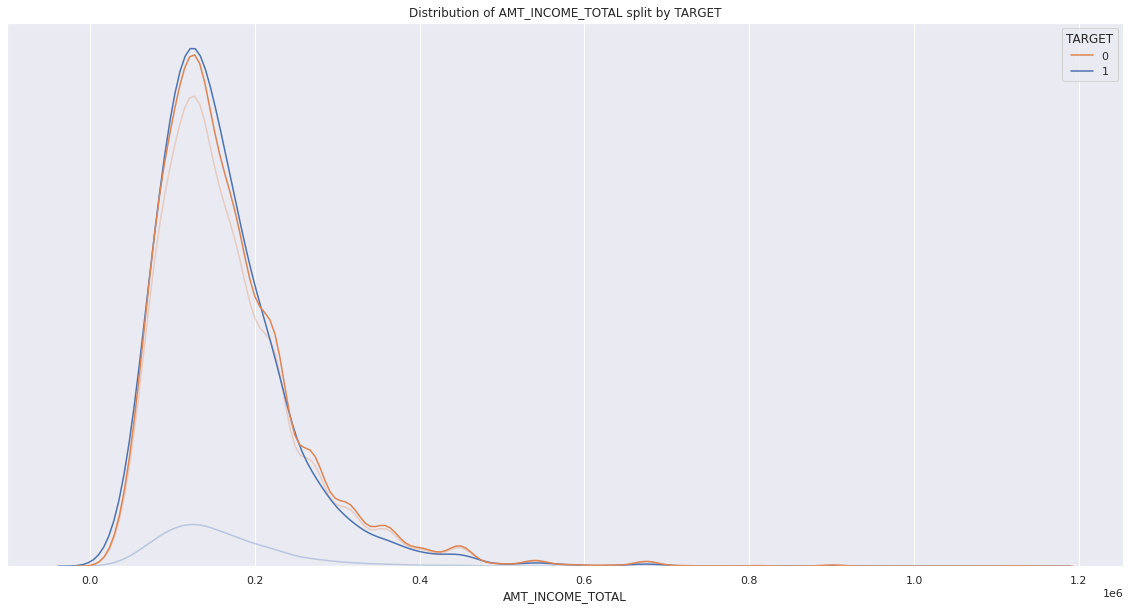

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["AMT_INCOME_TOTAL"] < 1170000],
    x="AMT_INCOME_TOTAL",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df[df["AMT_INCOME_TOTAL"] < 1170000],
    x="AMT_INCOME_TOTAL",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="AMT_INCOME_TOTAL", ylabel="")
ax.set_title("Distribution of AMT_INCOME_TOTAL split by TARGET")
ax.set_yticks([])
plt.show()

Suprisingly income of the applicant doesn't very much impact their ability to repay their loan.

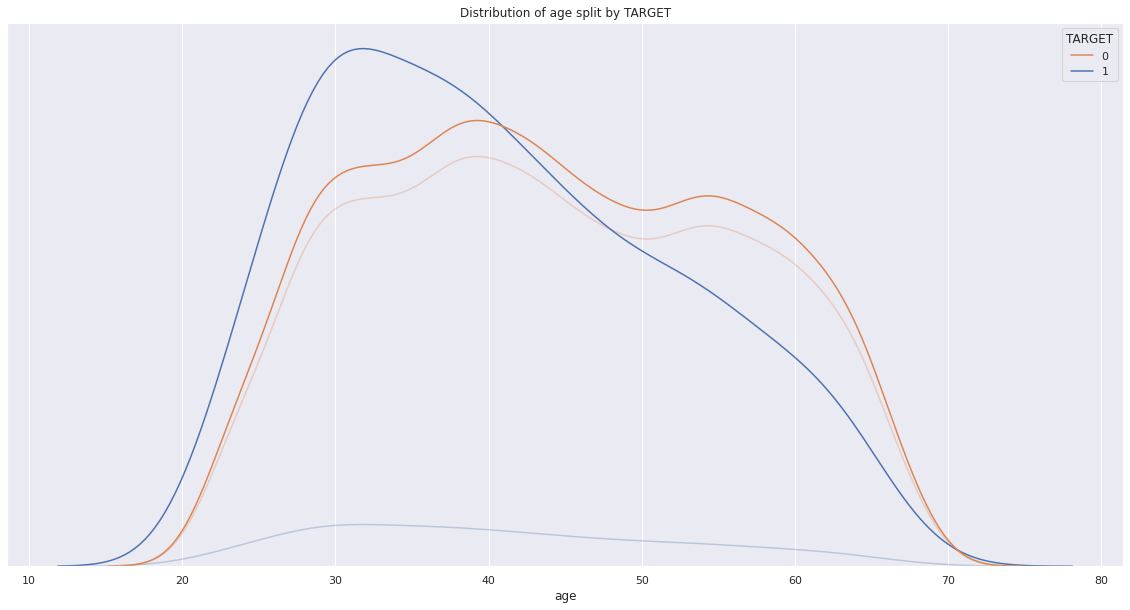

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="age",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df,
    x="age",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="age", ylabel="")
ax.set_title("Distribution of age split by TARGET")
ax.set_yticks([])
plt.show()

Applicant's age seems to be important for the TARGET - younger applicants are more likely to have trouble repaying their loan than older applicants.

In [ ]:
df.loc[df["DAYS_EMPLOYED"] > 0, "DAYS_EMPLOYED"].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

Feature "DAYS_EMPLOYED" contains only negative data, with exception of large amount of value "365243". I will be looking at those values as missing data.

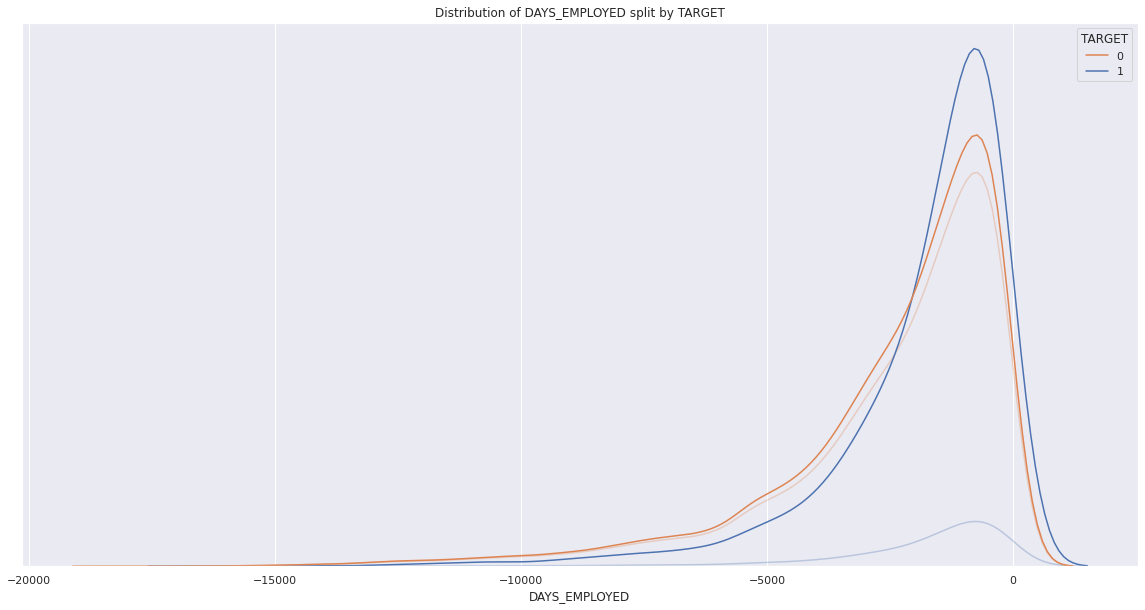

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df.loc[~(df["DAYS_EMPLOYED"] == 365243)],
    x="DAYS_EMPLOYED",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df.loc[~(df["DAYS_EMPLOYED"] == 365243)],
    x="DAYS_EMPLOYED",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="DAYS_EMPLOYED", ylabel="")
ax.set_title("Distribution of DAYS_EMPLOYED split by TARGET")
ax.set_yticks([])
plt.show()

Employement length of the applicant in the current workplace also seem to be important to whether the applicant will have payment difficulties.




## Data cleaning pt 1

Let's train a model using just the data from the main dataset. However we still need to do some data cleaning

In [ ]:
(df[df.columns[df.dtypes == "object"]] == "XNA").any()

NAME_CONTRACT_TYPE            False
CODE_GENDER                    True
FLAG_OWN_CAR                  False
FLAG_OWN_REALTY               False
NAME_TYPE_SUITE               False
NAME_INCOME_TYPE              False
NAME_EDUCATION_TYPE           False
NAME_FAMILY_STATUS            False
NAME_HOUSING_TYPE             False
OCCUPATION_TYPE               False
WEEKDAY_APPR_PROCESS_START    False
ORGANIZATION_TYPE              True
FONDKAPREMONT_MODE            False
HOUSETYPE_MODE                False
WALLSMATERIAL_MODE            False
EMERGENCYSTATE_MODE           False
dtype: bool

During EDA we noticed that there were two categorical features containing values "XNA" - symbolizing missing data. Let's take a closer look at those!

In [ ]:
(df["ORGANIZATION_TYPE"].value_counts() * 100 / df.shape[0]).head()

Business Entity Type 3    22.110429
XNA                       18.007161
Self-employed             12.491260
Other                      5.425172
Medicine                   3.639870
Name: ORGANIZATION_TYPE, dtype: float64

For ORGANIZATION_TYPE "XNA" is actually the second largest category! And as we saw in the EDA, the "XNA" category had a quite large difference in proportions when split by "TARGET" column. Maybe it contains people who aren't currently working?

In [ ]:
df["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [ ]:
df.loc[df["CODE_GENDER"] == "XNA", "CODE_GENDER"] = "F"

Second feature containing "XNA" is CODE_GENDER, with only 4 entries for the category. The amount of missing data is too small to justify more sophisticated methods - we will just convert them to the mode value.

In [ ]:
df[df.columns[df.dtypes == "object"]].nunique().sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [ ]:
(df["ORGANIZATION_TYPE"].value_counts() * 100 / df.shape[0]).head(40)

Business Entity Type 3    22.110429
XNA                       18.007161
Self-employed             12.491260
Other                      5.425172
Medicine                   3.639870
Business Entity Type 2     3.431747
Government                 3.383294
School                     2.891929
Trade: type 7              2.546576
Kindergarten               2.237318
Construction               2.185613
Business Entity Type 1     1.945947
Transport: type 4          1.755384
Trade: type 3              1.135569
Industry: type 9           1.095245
Industry: type 3           1.065978
Security                   1.055897
Housing                    0.961917
Industry: type 11          0.879318
Military                   0.856555
Bank                       0.815255
Agriculture                0.798020
Police                     0.761274
Transport: type 2          0.716722
Postal                     0.701438
Security Ministries        0.641928
Trade: type 2              0.617864
Restaurant                 0

There are a few categorical columns containing large amounts of categories, with a lot of these categories containing only a small fraction of the values in the feature. We will use a transformer to convert all categories whose value count s below a threshold to category "Other".

Let's see what we can do about the missing values next!

In [ ]:
df[df.columns[df.dtypes == "object"]].isna().sum() * 100 / df.shape[0]

NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
NAME_TYPE_SUITE                0.420148
NAME_INCOME_TYPE               0.000000
NAME_EDUCATION_TYPE            0.000000
NAME_FAMILY_STATUS             0.000000
NAME_HOUSING_TYPE              0.000000
OCCUPATION_TYPE               31.345545
WEEKDAY_APPR_PROCESS_START     0.000000
ORGANIZATION_TYPE              0.000000
FONDKAPREMONT_MODE            68.386172
HOUSETYPE_MODE                50.176091
WALLSMATERIAL_MODE            50.840783
EMERGENCYSTATE_MODE           47.398304
dtype: float64

For categorical features we will just leave the missing values in - One-hot-encoding will create seperate <feature_name>_nan columns to represent a missing value for the column.

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(10)

COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_MEDI       68.354953
dtype: float64

There are a lot of numerical features with large amounts of values missing. Let's take a closer look at some of them.

In [ ]:
best_corrs_common_area = (
    df.corrwith(df["COMMONAREA_MODE"]).sort_values(ascending=False).head(10)
)

In [ ]:
best_corrs_common_area

COMMONAREA_MODE          1.000000
COMMONAREA_MEDI          0.979887
COMMONAREA_AVG           0.977147
TOTALAREA_MODE           0.543141
LIVINGAPARTMENTS_MODE    0.538952
LIVINGAREA_MEDI          0.538446
LIVINGAREA_MODE          0.537778
LIVINGAREA_AVG           0.537318
APARTMENTS_MEDI          0.531577
APARTMENTS_AVG           0.529509
dtype: float64

In [ ]:
df.loc[
    df["COMMONAREA_MODE"].isna(), best_corrs_common_area.index
].isna().sum() * 100 / df.loc[df["COMMONAREA_MODE"].isna()].shape[0]

COMMONAREA_MODE          100.000000
COMMONAREA_MEDI          100.000000
COMMONAREA_AVG           100.000000
TOTALAREA_MODE            69.073139
LIVINGAPARTMENTS_MODE     96.710027
LIVINGAREA_MEDI           71.800433
LIVINGAREA_MODE           71.800433
LIVINGAREA_AVG            71.800433
APARTMENTS_MEDI           72.409653
APARTMENTS_AVG            72.409653
dtype: float64

Several of the features describing the area of where the applicant lives have been aggregated using mean, mode and median. Unsuprisingly these three resulting features are extremely closely correlated - which means we will need to drop some of them to avoid multicollinearity during modeling. We also can't use them to help impute the missing data in the other two columns for the same feature - they have missing values in the same entries. 

For each case of these almost-duplicate features we will check which has the best correlation with the target and drop the other two.

In [ ]:
mode_columns = df.columns[df.columns.str.contains("_MODE")].str.replace("_MODE", "")
mode_columns = mode_columns[
    mode_columns.isin(
        df.columns[df.columns.str.contains("_MEDI")].str.replace("_MEDI", "")
    )
    & mode_columns.isin(
        df.columns[df.columns.str.contains("_AVG")].str.replace("_AVG", "")
    )
]
for column in mode_columns:
    corr_series = df.loc[
        :, [column + "_AVG", column + "_MODE", column + "_MEDI"]
    ].corrwith(df["TARGET"])
    df = df.drop(
        corr_series[~(corr_series.index == corr_series.idxmax())].index, axis=1
    )

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(10)

COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MODE              67.848630
YEARS_BUILD_MODE            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_MODE               59.376738
BASEMENTAREA_MODE           58.515956
EXT_SOURCE_1                56.381073
dtype: float64

In [ ]:
drop_cols = columns_to_drop_due_multicoll(df)
drop_cols

{'AMT_ANNUITY',
 'AMT_CREDIT',
 'APARTMENTS_MODE',
 'CNT_FAM_MEMBERS',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_MODE',
 'FLOORSMIN_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT'}

We can see that there are some more features with high in-between correlation. We will drop them as part of our pipeline.

Our plan to deal with the missing values is to look up the highest correlations for each column that has a significant amount of data missing, then iteratively go through these correlated columns, bin them, find the mean missing_column value for each bin and impute the missing values. We will take several highest correlations for each of the missing_columns since it's possible that there will be some entries where the values are missing for both the correlated_column and the missing_column.

In [ ]:
best_corrs_means_dict, max_corr_pair_dict = get_best_corrs_missing_cols(df, drop_cols)
fillmissing = FillMissingDataCurrentOnly(
    best_corrs_means_dict, max_corr_pair_dict, drop_cols, fillna=False
)
df_temp = fillmissing.fit_transform(df)

In [ ]:
missing_data_changes = (
    df.loc[:, df.columns[~(df.dtypes == "object")]].isna().sum() * 100 / df.shape[0]
).to_frame()
missing_data_changes = missing_data_changes.join(
    pd.Series(
        df_temp.loc[:, df_temp.columns[~(df_temp.dtypes == "object")]].isna().sum()
        * 100
        / df.shape[0],
        name="missing_after",
    )
)
missing_data_changes = missing_data_changes.rename(columns={0: "missing_before"})

missing_data_changes.sort_values("missing_before", ascending=False).head(15)

,missing_before,missing_after
COMMONAREA_MODE,69.872297,0.0
NONLIVINGAPARTMENTS_MODE,69.432963,0.0
LIVINGAPARTMENTS_MODE,68.354953,NaN
FLOORSMIN_MODE,67.848630,NaN
YEARS_BUILD_MODE,66.497784,0.0
OWN_CAR_AGE,65.990810,0.0
LANDAREA_MODE,59.376738,0.0
BASEMENTAREA_MODE,58.515956,0.0
EXT_SOURCE_1,56.381073,0.0
NONLIVINGAREA_MODE,55.179164,0.0


After running the transformer we can see that all of the features that had large amounts of missing data now have either been dropped due to multicollinearity or have all of the missing data imputed. (I decided to run the imputing cycle twice, since after just doing one there were still some columns with large amounts of missing data. That means that some of the values have been imputed using previously imputed values in other columns, which is a slippery slope, but still might be closer to reality than just taking the median value) There are still some features with missing values and we will impute those by taking the median column value.

## Modelling using just current loan data

To speed up the training process, we will be using a sample of the data.

In [ ]:
df2 = df.copy()
df = df2.sample(frac=0.3, random_state=42)

In [ ]:
train_set, test_set, train_target, test_target = train_test_split(
    df.loc[:, df.columns[df.columns != "TARGET"]],
    df["TARGET"],
    test_size=0.2,
    random_state=42,
    stratify=df["TARGET"],
)

In [ ]:
drop_cols = columns_to_drop_due_multicoll(train_set.join(train_target))
best_corrs_means_dict, max_corr_pair_dict = get_best_corrs_missing_cols(
    train_set, drop_cols
)
one_hot_columns = df.columns[df.dtypes == "object"]
missing_dict = {"ORGANIZATION_TYPE": "XNA", "DAYS_EMPLOYED": 365243}

In [ ]:
OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)

Preprocessor = Pipeline(
    [
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "values_to_other",
            SmallValuesToOther(one_hot_columns[df[one_hot_columns].nunique() > 3]),
        ),
        (
            "fill_missing_data",
            FillMissingDataCurrentOnly(
                best_corrs_means_dict, max_corr_pair_dict, drop_cols, fillna=True
            ),
        ),
        ("one_hot_encode", OneHotPipeline),
    ]
)

Since our missing data imputer transformer takes a lot of time to compute, I decided to split the pipeline into two - Preprocessor pipeline and model. There shouldn't be any data leakage introduced by this.

In [ ]:
temp_df = Preprocessor.fit_transform(train_set)

In [ ]:
train_set_val, test_set_val, train_target_val, test_target_val = train_test_split(
    temp_df, train_target, test_size=0.2, random_state=42, stratify=train_target
)

full_pipe = imb_pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("oversampler", SMOTE(sampling_strategy="minority")),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

full_pipe.fit(train_set_val, train_target_val)

Since the target feature is imbalanced, we need to use some kind of over or undersampling. Here we will be using SMOTE for oversampling and logistic regression for modelling.

In [ ]:
average_precision_score(test_target_val, full_pipe.predict(test_set_val))

0.13072496492718338

Since the data is imbalanced, we're more interested in pr-auc score than the roc-auc and the pr-auc score we got from this first exploratory model is 0.13. Hopefully we can do better.

We have got quite a lot features, so maybe a more complicated model will be more successful in differentiating between the two classes. But first let's check which features seem to be most important by using shap.

In [ ]:
shap.initjs()

In [ ]:
transformer = Pipeline([("preprocessor", Preprocessor), ("scaler", MinMaxScaler())])

temp = Preprocessor.steps[2][1].column_names
column_names = np.concatenate(
    [
        Preprocessor.steps[3][1].transformers_[0][1].get_feature_names_out(),
        temp[~temp.isin(Preprocessor.steps[3][1].transformers_[0][2])],
    ]
)

train_shap = transformer.fit_transform(train_set)
test_shap = transformer.transform(test_set)
train_shap = pd.DataFrame(train_shap, index=train_set.index, columns=column_names)
test_shap = pd.DataFrame(test_shap, index=test_set.index, columns=column_names)

sampler = full_pipe[-2]
train_shap, train_shap_target = sampler.fit_resample(train_shap, train_target)

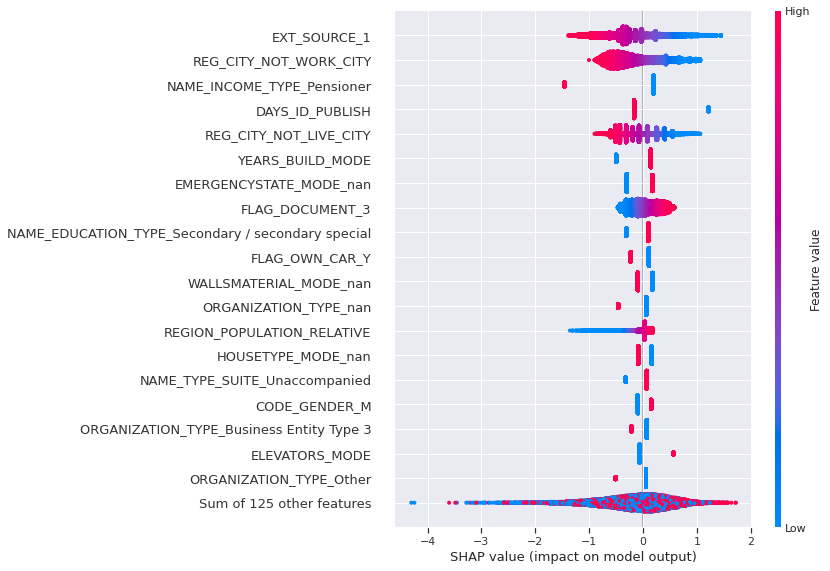

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(train_shap, train_shap_target)
explainer = shap.Explainer(log_reg, train_shap, feature_names=train_shap.columns)
shap_values = explainer(test_shap)

shap.plots.beeswarm(shap_values, max_display=20)

We can see that the most important feature is one of the risk score features. Then there's also whether the applicant is a pensioner, the gender of the applicant, whether they own a car. Interesting thing to notice is that as some of the top predictors we have several <categorical_feature_name>_nan columns - whether the value of a categorical feature for the applicant was missing or not. That implies that the data is not missing at random.

Next let's train an xgboost model on the data.

In [ ]:
def objective_booster_class_imb(trial, X: pd.DataFrame, y: pd.Series):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.7)
    n_estimators = trial.suggest_int("n_estimators", 10, 250)
    max_depth = trial.suggest_int("max_depth", 2, 5, log=True)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 1e-10, 0.1)
    scale_pos_weight = trial.suggest_int("scale_pos_weight", 5, 9)
    num_boost_round = trial.suggest_int("num_boost_round", 60, 110)

    skf = StratifiedKFold(n_splits=3)

    score = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_xg_DMatrix = xg.DMatrix(data=X_train, label=y_train)
        test_xg_DMatrix = xg.DMatrix(data=X_test, label=y_test)

        params = {
            "learning_rate": learning_rate,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_impurity_decrease": min_impurity_decrease,
            "scale_pos_weight": scale_pos_weight,
            "booster": "gbtree",
        }

        model = xg.train(
            params, train_xg_DMatrix, feval="aucpr", num_boost_round=num_boost_round
        )
        result = np.round(model.predict(test_xg_DMatrix))
        score.append(average_precision_score(y_test, result))

    print(score)

    pr_auc = pd.Series(score).mean()
    return pr_auc

In [ ]:
grade_wrapper = lambda trial: objective_booster_class_imb(trial, temp_df, train_target)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=40)

Best value we got after training xgboost on optuna was 0.1396 - only a fractional increase.

Let's try it on the test data.

In [ ]:
temp_df_test = Preprocessor.transform(test_set)
train_xg_DMatrix = xg.DMatrix(data=temp_df, label=train_target)
test_xg_DMatrix = xg.DMatrix(data=temp_df_test, label=test_target)

params = {
    "learning_rate": 0.1630032963273184,
    "n_estimators": 90,
    "max_depth": 2,
    "min_impurity_decrease": 0.028707880840137423,
    "scale_pos_weight": 8,
    "booster": "gbtree",
}
model = xg.train(params, train_xg_DMatrix, feval="aucpr", num_boost_round=73)
result = np.round(model.predict(test_xg_DMatrix))

In [ ]:
average_precision_score(test_target, result)

0.13522014345791417

In [ ]:
roc_auc_score(test_target, result)

0.6563387692925926

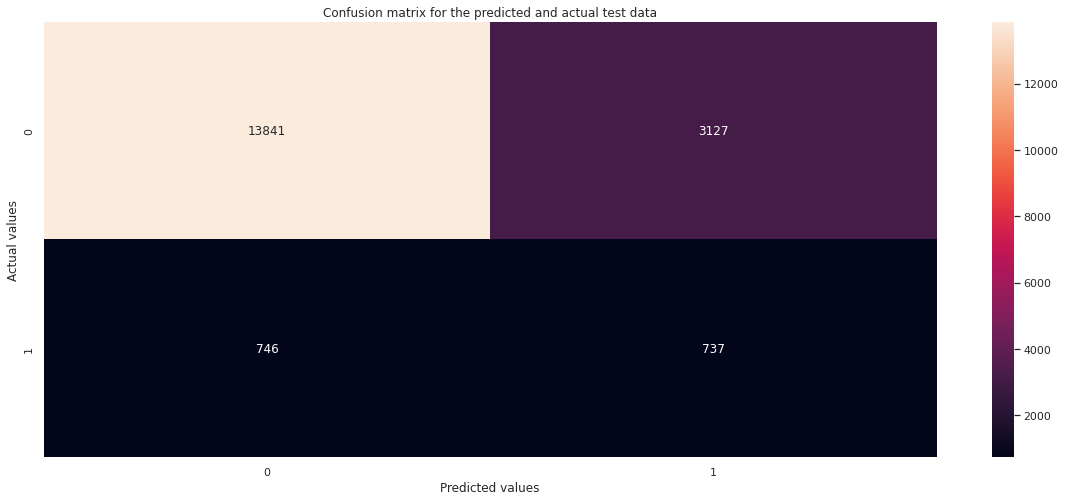

In [ ]:
matrix = confusion_matrix(test_target, result)
label_list = ["0", "1"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

We can see that the model has correctly predicted 4/5 of the negative data and around half of the positive data. 

Hopefully we can get better results by adding data from the other datasets!

## Other datasets EDA

### POS_CASH_balance dataset

In [ ]:
id = "1d_tfWpm41vpu4PSSmnZT24bDJioQ5bln"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("POS_CASH_balance.csv")
df_pos_cash = pd.read_csv("POS_CASH_balance.csv")

In [ ]:
df_pos_cash.head(15)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [ ]:
df_pos_cash.shape[0]

10001358

In [ ]:
df_pos_cash["SK_ID_PREV"].nunique()

936325

Dataset containing monthly information about past cash loans applicators have taken with the Home Credit has 10 million entries between 900 thousand past loans.

In [ ]:
df_pos_cash.groupby("SK_ID_PREV")["SK_DPD"].count().value_counts().head()

7     116659
13    103901
11     86312
6      67652
8      63955
Name: SK_DPD, dtype: int64

Most of the loans have between 6 and 13 entries. 

In [ ]:
df_pos_cash["any_DPD"] = df_pos_cash["SK_DPD"] > 0
df_pos_cash.groupby("SK_ID_PREV")["any_DPD"].max().value_counts()

False    859293
True      77032
Name: any_DPD, dtype: int64

Only 77 thousand of the past loans have had any late payments. 

Let's take a look at one of these loans.

In [ ]:
df_pos_cash = df_pos_cash.drop("any_DPD", axis=1)

In [ ]:
df_pos_cash[df_pos_cash["SK_ID_PREV"] == 2448283].sort_values("MONTHS_BALANCE").head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1439944,2448283,226558,-53,6.0,6.0,Active,0,0
3290550,2448283,226558,-52,6.0,5.0,Active,0,0
9476097,2448283,226558,-51,6.0,4.0,Active,0,0
5952719,2448283,226558,-50,6.0,3.0,Active,0,0
5916746,2448283,226558,-49,6.0,2.0,Active,0,0
7696039,2448283,226558,-48,6.0,1.0,Active,0,0
5716028,2448283,226558,-47,6.0,0.0,Active,20,0
1782433,2448283,226558,-46,6.0,0.0,Active,50,0
7464551,2448283,226558,-45,6.0,0.0,Active,81,0
5744905,2448283,226558,-44,6.0,0.0,Active,112,0


We can see that for this loan the last payment was the one that was late and it did not get paid for the next several months as well.

In [ ]:
df_pos_cash.loc[
    (
        df_pos_cash.loc[df_pos_cash["SK_DPD"] > 0].groupby("SK_ID_PREV")["SK_DPD"]
    ).idxmin(),
    "CNT_INSTALMENT_FUTURE",
].value_counts().head()

0.0    11868
1.0     7310
2.0     6476
3.0     5915
4.0     5537
Name: CNT_INSTALMENT_FUTURE, dtype: int64

Interesting that between the loans that have any days past due, most have been late on the last payment.

Let's take a look at the payments for this loan.

In [ ]:
id = "1_3OlhoanFAX5BMVwc0mvbCIuYGG2XOTv"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("installments_payments.csv")
payments_df = pd.read_csv("installments_payments.csv")

In [ ]:
payments_df[payments_df["SK_ID_PREV"] == 2448283].sort_values(
    "DAYS_ENTRY_PAYMENT"
).head(15)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
7488149,2448283,226558,1.0,1,-1593.0,-1603.0,3880.305,3880.305
6139045,2448283,226558,1.0,2,-1563.0,-1570.0,3880.305,3880.305
5710890,2448283,226558,1.0,3,-1533.0,-1535.0,3880.305,3880.305
4831186,2448283,226558,1.0,4,-1503.0,-1503.0,3880.305,3880.305
7362866,2448283,226558,1.0,5,-1473.0,-1472.0,3880.305,3880.305
6627705,2448283,226558,1.0,6,-1443.0,-1442.0,3885.660,3880.305
7130666,2448283,226558,1.0,6,-1443.0,-581.0,3885.660,5.355


We can see that for this loan the last payment was not paid in full and only after almost 3 year delay the loan got completely repaid.

Let's take a look at another.

In [ ]:
df_pos_cash[df_pos_cash["SK_ID_PREV"] == 1839550].sort_values("MONTHS_BALANCE").head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
5037567,1839550,412432,-66,16.0,16.0,Active,0,0
8717508,1839550,412432,-65,16.0,15.0,Active,0,0
8247229,1839550,412432,-64,16.0,14.0,Active,0,0
8792560,1839550,412432,-63,16.0,13.0,Active,0,0
5818109,1839550,412432,-62,16.0,12.0,Active,0,0
7632634,1839550,412432,-61,16.0,11.0,Active,0,0
7667843,1839550,412432,-60,16.0,10.0,Active,0,0
8906437,1839550,412432,-59,16.0,9.0,Active,0,0
8748731,1839550,412432,-58,16.0,8.0,Active,0,0
6812507,1839550,412432,-57,16.0,7.0,Active,0,0


For this loan the last 6 payments got paid 10 days late.

None of the data in payments dataframe does not seem to be very useful for predicting current loans.

In [ ]:
100 - (
    df_pos_cash.groupby("SK_ID_PREV")["SK_DPD"].max().value_counts()[0]
    * 100
    / df_pos_cash["SK_ID_PREV"].nunique()
)

8.227057912583774

Returning to the dataframe containing past cash loans, we can see that around 8 % of the loans there have had any days past due. The percentage is not too huge, but a usable amount.

In [ ]:
100 - (
    (
        df_pos_cash.groupby("SK_ID_PREV")["SK_DPD"]
        .max()
        .value_counts()
        .sort_index()
        .loc[0:30]
    ).sum()
    * 100
    / df_pos_cash["SK_ID_PREV"].nunique()
)

0.896803994339578

Looking at the percentage of loans that have had at least 30 days past due, it is 10 times smaller than the previous number.

In [ ]:
df_cash_grouped = (
    df_pos_cash.groupby(["SK_ID_PREV", "CNT_INSTALMENT_FUTURE"])["SK_DPD"]
    .max()
    .reset_index()
    .groupby("SK_ID_PREV")["SK_DPD"]
    .sum()
    .to_frame()
)
df_cash_grouped["last_DPD_cash"] = (
    df_pos_cash[df_pos_cash["SK_DPD"] > 0].groupby("SK_ID_PREV")["MONTHS_BALANCE"].max()
)
df_pos_cash["active_completed_cash"] = (
    df_pos_cash["NAME_CONTRACT_STATUS"] == "Completed"
)
df_cash_grouped["completed_cash"] = df_pos_cash.groupby("SK_ID_PREV")[
    "active_completed_cash"
].max()
df_cash_grouped = df_cash_grouped.rename(columns={"SK_DPD": "DPD_cash_sum"})
df_cash_grouped = df_cash_grouped.reset_index()

Since for each loan there are several rows in this dataset, we will need to aggregate the rows to be able to use the data together with our main data. We will sum the days past due for each loan, and we will take the amount of months since the last time the payment for the loan was late. Also we will check whether the loans have been completed to the date or not.

Let's merge the data we got from the cash loan monthly dataset with main past loan dataset.

In [ ]:
id = "1XyCtB-oj6i7i3JhFSY6GopeezSq747Ed"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("previous_application.csv")
prev_df = pd.read_csv("previous_application.csv")

In [ ]:
(
    df_cash_grouped["SK_ID_PREV"].isin(prev_df["SK_ID_PREV"]).sum()
    * 100
    / df_cash_grouped.shape[0]
).round(2)

96.0

There seem to be some monthly loan data without an entry in the main past loan dataset.

In [ ]:
(
    df_cash_grouped.loc[df_cash_grouped["DPD_cash_sum"] > 0, "SK_ID_PREV"]
    .isin(prev_df["SK_ID_PREV"])
    .sum()
    * 100
    / df_cash_grouped.loc[df_cash_grouped["DPD_cash_sum"] > 0].shape[0]
).round(2)

93.09

While the percentage of missing entries in the main dataset is larger for the loans with missing payments, the difference isn't too large.

In [ ]:
df_cash_grouped = df_cash_grouped[
    df_cash_grouped["SK_ID_PREV"].isin(prev_df["SK_ID_PREV"])
]
prev_df = prev_df.merge(
    df_cash_grouped, how="left", right_on="SK_ID_PREV", left_on="SK_ID_PREV"
)

### credit_card_balance dataset

Next we'll look at the monthly data of past credit card loans.

In [ ]:
id = "1_xsmimM0xoDVFnDvcCHmsqiVpixKeIiN"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("credit_card_balance.csv")
credit_df = pd.read_csv("credit_card_balance.csv")

In [ ]:
credit_df.head(18)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,1800.000,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,2250.000,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,2250.000,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,11925.000,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,27000.000,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,3825.000,3825.000,80519.040,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,15750.000,15750.000,345433.860,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,264.690,0.000,44735.310,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,4093.515,4093.515,285376.410,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,45000.000,45000.000,192793.275,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [ ]:
credit_df.shape[0]

3840312

In [ ]:
credit_df["SK_ID_PREV"].nunique()

104307

In [ ]:
credit_df.groupby("SK_ID_PREV")["MONTHS_BALANCE"].count().max()

96

There are 4 million entries for 100 thousand different credit cards with maximum of 96 entries for a single loan.

In [ ]:
credit_df[credit_df["SK_ID_PREV"] == 1891521].sort_values("MONTHS_BALANCE").tail(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3357348,1891521,126868,-10,453125.430,450000,0.0,9403.020,0.0,9403.020,23030.235,27000.0,27000.0,443007.495,453125.430,453125.430,0.0,3,0.0,3.0,92.0,Active,0,0
2367732,1891521,126868,-9,447473.655,450000,0.0,10255.455,0.0,10255.455,22656.285,27000.0,27000.0,436380.885,447473.655,447473.655,0.0,1,0.0,1.0,93.0,Active,0,0
2881856,1891521,126868,-8,444437.685,450000,0.0,13288.500,0.0,13288.500,22373.685,27000.0,27000.0,433762.155,444437.685,444437.685,0.0,3,0.0,3.0,94.0,Active,0,0
1112162,1891521,126868,-7,450578.025,450000,0.0,22095.540,0.0,22095.540,22221.900,27000.0,27000.0,439533.225,450578.025,450578.025,0.0,3,0.0,3.0,95.0,Active,0,0
3623461,1891521,126868,-6,457992.720,450000,0.0,23611.950,0.0,23611.950,22528.890,27000.0,27000.0,447189.975,457992.720,457992.720,0.0,3,0.0,3.0,96.0,Active,0,0
56769,1891521,126868,-5,459959.130,450000,0.0,17469.000,0.0,17469.000,22899.645,27000.0,27000.0,448461.720,459959.130,459959.130,0.0,1,0.0,1.0,97.0,Active,0,0
2611945,1891521,126868,-4,457896.285,450000,0.0,13675.500,0.0,13675.500,22997.970,27000.0,27000.0,446634.630,457896.285,457896.285,0.0,4,0.0,4.0,98.0,Active,0,0
728020,1891521,126868,-3,461330.505,450000,18000.0,18000.000,0.0,0.000,22894.830,27000.0,27000.0,448896.285,461330.505,461330.505,1.0,1,0.0,0.0,99.0,Active,0,0
1701346,1891521,126868,-2,458497.395,450000,0.0,13113.405,0.0,13113.405,23066.505,27000.0,27000.0,447443.910,458497.395,458497.395,0.0,2,0.0,2.0,100.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
round(
    (credit_df.groupby("SK_ID_PREV")["AMT_DRAWINGS_ATM_CURRENT"].sum() > 0).sum()
    * 100
    / credit_df["SK_ID_PREV"].nunique(),
    2,
)

57.75

58% of the credit cards have withdrawn funds via ATM.

In [ ]:
round(
    credit_df[credit_df["SK_DPD"] > 0].groupby("SK_ID_PREV").sum().shape[0]
    * 100
    / credit_df["SK_ID_PREV"].nunique(),
    2,
)

19.82

Around 20 % of the credit cards have ever had any late payments.

In [ ]:
df_credit_grouped = (
    credit_df.groupby(["SK_ID_PREV", "CNT_INSTALMENT_MATURE_CUM"])["SK_DPD"]
    .max()
    .reset_index()
    .groupby("SK_ID_PREV")["SK_DPD"]
    .sum()
    .to_frame()
)
df_credit_grouped["last_DPD_credit"] = (
    credit_df[credit_df["SK_DPD"] > 0].groupby("SK_ID_PREV")["MONTHS_BALANCE"].max()
)
df_credit_grouped["atm_drawings_vs_all_drawings_credit"] = (
    credit_df.groupby("SK_ID_PREV")["AMT_DRAWINGS_ATM_CURRENT"].sum()
    / credit_df.groupby("SK_ID_PREV")["AMT_DRAWINGS_CURRENT"].sum()
)
credit_df["balance_over_limit_credit"] = (
    credit_df["AMT_CREDIT_LIMIT_ACTUAL"] < credit_df["AMT_BALANCE"]
)
df_credit_grouped["balance_over_limit_credit_count"] = credit_df.groupby("SK_ID_PREV")[
    "balance_over_limit_credit"
].sum()
df_credit_grouped["balance_over_limit_credit_ratio"] = (
    credit_df.groupby("SK_ID_PREV")["AMT_BALANCE"].sum()
    / credit_df.groupby("SK_ID_PREV")["AMT_CREDIT_LIMIT_ACTUAL"].sum()
)
df_credit_grouped["amount_per_drawing_credit_mean"] = (
    credit_df.groupby("SK_ID_PREV")["AMT_DRAWINGS_CURRENT"].sum()
    / credit_df.groupby("SK_ID_PREV")["CNT_DRAWINGS_CURRENT"].sum()
)
credit_df["active_completed_credit"] = credit_df["NAME_CONTRACT_STATUS"] == "Completed"
df_credit_grouped["completed_credit"] = credit_df.groupby("SK_ID_PREV")[
    "active_completed_credit"
].max()
df_credit_grouped["all_drawings_credit_sum"] = credit_df.groupby("SK_ID_PREV")[
    "AMT_DRAWINGS_CURRENT"
].sum()
df_credit_grouped = df_credit_grouped.rename(columns={"SK_DPD": "DPD_credit_sum"})
df_credit_grouped = df_credit_grouped.reset_index()

In this dataset there is more data that might be useful for us and that we need to aggregate. First we will again sum all the days past due for each loan, then, again, take the count of months since the last late payment. We will also take the ratio of amount drawn from ATM against the total amount of funds withdrawn and also the ratio of monthly balance against credit limit. The count of times balance has been over the credit limit might also be relevant to us, as well as the mean amount that has been taken out from the card in a single drawing. Finally, we will check whether the loan is active or not and compute the total sum of all drawings from the card.

### previous_application dataset

Next let's take a closer look at the dataset containing general data about the previous loans taken from Home Credit company by the applicants.

In [ ]:
df_credit_grouped = df_credit_grouped[
    df_credit_grouped["SK_ID_PREV"].isin(prev_df["SK_ID_PREV"])
]
prev_df = prev_df.merge(
    df_credit_grouped, how="left", right_on="SK_ID_PREV", left_on="SK_ID_PREV"
)

In [ ]:
prev_df.head(18)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,DPD_cash_sum,last_DPD_cash,completed_cash,DPD_credit_sum,last_DPD_credit,atm_drawings_vs_all_drawings_credit,balance_over_limit_credit_count,balance_over_limit_credit_ratio,amount_per_drawing_credit_mean,completed_credit,all_drawings_credit_sum
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.0,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.0,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0,0.0,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_df[prev_df == "XNA"] = np.nan
prev_df[prev_df == "XAP"] = np.nan
prev_df.loc[prev_df["SELLERPLACE_AREA"] == -1, "SELLERPLACE_AREA"] = np.nan

First, we can see that, while there are Nan values present in the data, there seem to be several other values that also signify missing data. XNA seems to mean "not available", "while "XAP" - not appropriate (It's not appropriate to have a value for column CODE_REJECT_REASON	if the loan in question was accepted). -1 value for the "SELLERPLACE_AREA" feature also seems to mean missing data.

In [ ]:
(prev_df == 365243.0).sum().sort_values(ascending=False).head(7)

DAYS_FIRST_DRAWING           934444
DAYS_TERMINATION             225913
DAYS_LAST_DUE                211221
DAYS_LAST_DUE_1ST_VERSION     93864
DAYS_FIRST_DUE                40645
SK_ID_CURR                        1
SK_ID_PREV                        0
dtype: int64

In [ ]:
prev_df.loc[prev_df["DAYS_LAST_DUE"] > 0, "DAYS_LAST_DUE"].value_counts()

365243.0    136717
Name: DAYS_LAST_DUE, dtype: int64

Several columns containing only otherwise negative data also contain large amounts of value "365243.0". It seems likely that this also signifies missing data.

In [ ]:
prev_df.loc[:, prev_df.columns.drop("SK_ID_CURR")] = prev_df.loc[
    :, prev_df.columns.drop("SK_ID_CURR")
].replace(365243.0, np.nan)

There is a feature in the dataset that might flag duplicate data - "FLAG_LAST_APPL_PER_CONTRACT".

In [ ]:
df_descriptions.loc[186, "Description"]

'Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract'

Let's take a closer look at it!

In [ ]:
prev_df[prev_df["FLAG_LAST_APPL_PER_CONTRACT"] == "N"].head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
277,2770539,185661,Revolving loans,6750.0,0.0,180000.0,NaN,NaN,THURSDAY,11,N,0,NaN,NaN,NaN,NaN,Refused,-2621,NaN,NaN,NaN,Repeater,NaN,Cards,x-sell,Country-wide,2024.0,Consumer electronics,0.0,NaN,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
366,2139354,388401,Revolving loans,29250.0,0.0,585000.0,NaN,NaN,THURSDAY,15,N,1,NaN,NaN,NaN,NaN,Refused,-608,NaN,HC,NaN,Repeater,NaN,Cards,x-sell,AP+ (Cash loan),5.0,NaN,0.0,NaN,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
468,2470545,148658,Revolving loans,7875.0,0.0,157500.0,NaN,NaN,FRIDAY,9,N,1,NaN,NaN,NaN,NaN,Refused,-419,NaN,HC,NaN,Repeater,NaN,Cards,x-sell,AP+ (Cash loan),4.0,NaN,0.0,NaN,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
482,2319125,218182,Revolving loans,22500.0,337500.0,900000.0,NaN,337500.0,TUESDAY,12,N,0,NaN,NaN,NaN,NaN,Refused,-667,NaN,HC,NaN,Repeater,NaN,Cards,x-sell,Credit and cash offices,NaN,NaN,0.0,NaN,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
503,2195939,340546,Revolving loans,9000.0,0.0,67500.0,NaN,NaN,SUNDAY,13,N,1,NaN,NaN,NaN,NaN,Refused,-2725,NaN,HC,NaN,Repeater,NaN,Cards,x-sell,Country-wide,71.0,Connectivity,0.0,NaN,Card Street,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_df[prev_df["SK_ID_CURR"] == 185661].sort_values(
    ["DAYS_DECISION", "NFLAG_LAST_APPL_IN_DAY"]
).head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
227724,1546641,185661,Consumer loans,6563.835,131521.5,140854.5,13945.5,131521.5,FRIDAY,12,Y,1,0.098113,NaN,NaN,NaN,Approved,-2690,Cash through the bank,NaN,Unaccompanied,Repeater,Audio/Video,POS,NaN,Country-wide,NaN,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-2659.0,-1969.0,-1999.0,-1995.0,1.0
277,2770539,185661,Revolving loans,6750.000,0.0,180000.0,NaN,NaN,THURSDAY,11,N,0,NaN,NaN,NaN,NaN,Refused,-2621,NaN,NaN,NaN,Repeater,NaN,Cards,x-sell,Country-wide,2024.0,Consumer electronics,0.0,NaN,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1216415,2229583,185661,Revolving loans,6750.000,0.0,135000.0,NaN,NaN,THURSDAY,12,Y,1,NaN,NaN,NaN,NaN,Approved,-2621,NaN,NaN,NaN,Repeater,NaN,Cards,x-sell,Country-wide,2024.0,Consumer electronics,0.0,NaN,Card Street,-2620.0,-2564.0,365243.0,-1651.0,-19.0,0.0
348373,2318645,185661,Consumer loans,27447.255,258039.0,247050.0,25807.5,258039.0,THURSDAY,9,Y,1,0.103009,NaN,NaN,NaN,Approved,-1963,Cash through the bank,NaN,"Spouse, partner",Repeater,Construction Materials,POS,NaN,Stone,30.0,Construction,10.0,low_normal,POS industry with interest,365243.0,-1926.0,-1656.0,-1716.0,-1708.0,0.0
164099,2046119,185661,Consumer loans,19172.925,425592.0,425592.0,0.0,425592.0,TUESDAY,8,Y,1,0.000000,NaN,NaN,NaN,Approved,-908,Cash through the bank,NaN,Unaccompanied,Repeater,Audio/Video,POS,NaN,Country-wide,1200.0,Consumer electronics,24.0,low_action,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_df["SK_ID_PREV"].value_counts().max()

1

Taking a closer look at one of the cases where the loan application is not the last for the contract, we can see that indeed, in the same day there has been an another loan for the same applicant. However, if we take a closer look at the two loans, we can see that one was rejected, while the other was accepted. Also there are no duplicate ids for the previous loans. Seems like there is no actual duplicate data.

In [ ]:
(prev_df.isna().sum() * 100 / prev_df.shape[0]).sort_values(ascending=False).head(15)

RATE_INTEREST_PRIVILEGED               99.643698
RATE_INTEREST_PRIMARY                  99.643698
last_DPD_credit                        99.148852
atm_drawings_vs_all_drawings_credit    96.283171
amount_per_drawing_credit_mean         96.283051
NAME_CASH_LOAN_PURPOSE                 95.830774
last_DPD_cash                          95.706478
balance_over_limit_credit_ratio        94.496274
DPD_credit_sum                         94.435743
all_drawings_credit_sum                94.435743
balance_over_limit_credit_count        94.435743
completed_credit                       94.435743
CODE_REJECT_REASON                     81.327123
NAME_PRODUCT_TYPE                      63.684414
NAME_GOODS_CATEGORY                    56.927376
dtype: float64

There are three columns with extreme amounts of missing data - more than 99%. We will drop columns "RATE_INTEREST_PRIVILEGED" and "RATE_INTEREST_PRIMARY", but keep "last_DPD_credit" - missing data for the third column just signifies that the loan is either for cash not credit card, or that the applicant has never been late on the payments for the loan.

In [ ]:
cols_to_drop = [
    "FLAG_LAST_APPL_PER_CONTRACT",
    "NFLAG_LAST_APPL_IN_DAY",
    "NAME_CLIENT_TYPE",
    "DAYS_FIRST_DRAWING",
    "DAYS_FIRST_DUE",
    "DAYS_LAST_DUE_1ST_VERSION",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
    "RATE_INTEREST_PRIVILEGED",
    "RATE_INTEREST_PRIMARY",
]

In [ ]:
prev_df = prev_df.drop(cols_to_drop, axis=1)

I also dropped several columns that I could not see how to use for predicting the TARGET column

In [ ]:
prev_df.loc[:, prev_df.columns[prev_df.dtypes == "object"]].nunique().sort_values()

NAME_PRODUCT_TYPE              2
completed_cash                 2
completed_credit               2
NAME_CONTRACT_TYPE             3
NAME_PAYMENT_TYPE              3
NAME_CONTRACT_STATUS           4
NAME_PORTFOLIO                 4
NAME_YIELD_GROUP               4
WEEKDAY_APPR_PROCESS_START     7
CODE_REJECT_REASON             7
NAME_TYPE_SUITE                7
CHANNEL_TYPE                   8
NAME_SELLER_INDUSTRY          10
PRODUCT_COMBINATION           17
NAME_CASH_LOAN_PURPOSE        23
NAME_GOODS_CATEGORY           27
dtype: int64

There are some categorical columns with a large amount of different values - since we will be one-hot-encoding, to reduce the amount of resulting features we will convert all the categories that have small amount of entries to the "Other" category.

In [ ]:
binary_cols = prev_df.columns[(prev_df.nunique() == 2) & ~(prev_df.dtypes == "object")]
categorical_cols = prev_df.columns[prev_df.dtypes == "object"].append(binary_cols)

one_hot_previous = Pipeline(
    [
        (
            "values_to_other",
            SmallValuesToOther(
                categorical_cols[prev_df[categorical_cols].nunique() > 3]
            ),
        ),
        ("one_hot_encode", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ]
)

one_hot_categorical_df = one_hot_previous.fit_transform(
    prev_df.loc[:, categorical_cols]
)
one_hot_categorical_df = pd.DataFrame(
    one_hot_categorical_df,
    columns=one_hot_previous.steps[1][1].get_feature_names_out(),
    index=prev_df.index,
)

In [ ]:
joblib.dump(one_hot_previous, "one_hot_previous.pkl")

['one_hot_previous.pkl']

In [ ]:
prev_df.loc[
    prev_df["NAME_CONTRACT_TYPE"] == "Cash loans", categorical_cols
].isna().sum() * 100 / prev_df[prev_df["NAME_CONTRACT_TYPE"] == "Cash loans"].shape[0]

NAME_CONTRACT_TYPE              0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
NAME_CASH_LOAN_PURPOSE         90.684941
NAME_CONTRACT_STATUS            0.000000
NAME_PAYMENT_TYPE              45.925707
CODE_REJECT_REASON             78.005038
NAME_TYPE_SUITE                56.377140
NAME_GOODS_CATEGORY           100.000000
NAME_PORTFOLIO                 38.256819
NAME_PRODUCT_TYPE              38.256819
CHANNEL_TYPE                    0.000000
NAME_SELLER_INDUSTRY           93.532231
NAME_YIELD_GROUP               38.256819
PRODUCT_COMBINATION             0.000000
completed_cash                 61.404609
completed_credit              100.000000
NFLAG_INSURED_ON_APPROVAL      61.369160
dtype: float64

There were some missing values in the categorical features. One hot encoding made a seperate <feature_name>_nan column in each of these cases. For most part I think it might be even useful - there might be a reason why these values are missing. However there are cases where the values in a column are missing just because the feature is not valid for the loan in question. We will try to keep the information about valid missing info while avoiding cases where a value does not make sense.

In [ ]:
one_hot_categorical_df.columns = one_hot_categorical_df.columns.str.replace(
    "[^a-zA-Z\d\s]", " ", regex=True
)
one_hot_categorical_df.columns = one_hot_categorical_df.columns.str.replace(
    "\s+", "_", regex=True
)

one_hot_categorical_df.loc[
    ~(one_hot_categorical_df["NAME_CONTRACT_STATUS_Approved"] == 1),
    ["completed_cash_nan", "completed_credit_nan", "NFLAG_INSURED_ON_APPROVAL_nan"],
] = 0
one_hot_categorical_df.loc[
    one_hot_categorical_df["NAME_CONTRACT_STATUS_Approved"] == 1,
    "CODE_REJECT_REASON_nan",
] = 0
one_hot_categorical_df.loc[
    one_hot_categorical_df["NAME_CONTRACT_STATUS_Approved"] == 1,
    "CODE_REJECT_REASON_nan",
] = 0

one_hot_categorical_df.loc[
    one_hot_categorical_df["NAME_CONTRACT_TYPE_Revolving_loans"] == 1,
    [
        "NAME_PAYMENT_TYPE_nan",
        "NAME_YIELD_GROUP_nan",
        "NAME_CASH_LOAN_PURPOSE_nan",
        "completed_cash_nan",
    ],
] = 0
one_hot_categorical_df.loc[
    one_hot_categorical_df["NAME_CONTRACT_TYPE_Cash_loans"] == 1,
    ["NAME_GOODS_CATEGORY_nan", "completed_credit_nan"],
] = 0
one_hot_categorical_df.loc[
    one_hot_categorical_df["NAME_CONTRACT_TYPE_Consumer_loans"] == 1,
    ["NAME_CASH_LOAN_PURPOSE_nan", "NAME_PRODUCT_TYPE_nan", "completed_credit_nan"],
] = 0

In [ ]:
num_columns = prev_df.columns[
    (~(prev_df.dtypes == "object") & ~prev_df.columns.isin(binary_cols))
]
num_df = prev_df.loc[:, num_columns]

prev_df = num_df.join(one_hot_categorical_df)
del one_hot_categorical_df
del num_df

Since there can be several past loans for each current loan, we yet again have to aggregate the values.

In [ ]:
prev_df_grouped = prev_df.groupby("SK_ID_CURR")[
    np.append(
        prev_df.columns.drop(num_columns),
        ["DPD_cash_sum", "DPD_credit_sum", "balance_over_limit_credit_count"],
    )
].sum()
prev_df_grouped.columns = prev_df_grouped.columns + "_sum"

We will be taking the sum for all of the features we one-hot-encoded and also several others - how many cash loans has a current applicant taken previously? How many rejected loans does he have? Etc.

In [ ]:
mean_cols = num_columns.drop(
    [
        "SK_ID_PREV",
        "SK_ID_CURR",
        "DAYS_DECISION",
        "last_DPD_cash",
        "last_DPD_credit",
        "DPD_cash_sum",
        "DPD_credit_sum",
        "balance_over_limit_credit_count",
    ]
)
temp_grouped = prev_df.groupby("SK_ID_CURR")[mean_cols].mean()
temp_grouped.columns = temp_grouped.columns + "_mean"
prev_df_grouped = prev_df_grouped.join(temp_grouped)

For most of the remaining features we will be taking the mean - What is the mean loan size the current applicant previously applied for? What is the mean hour the applicant previously applied for the loan at?

In [ ]:
temp_grouped = prev_df.groupby("SK_ID_CURR")[
    "DAYS_DECISION", "last_DPD_cash", "last_DPD_credit"
].max()
temp_grouped.columns = temp_grouped.columns + "_max"
prev_df_grouped = prev_df_grouped.join(temp_grouped)

And there are a few columns containing timedelta data, for whom we will take the max value - when was the last time the current loan applicant was late on payments on any of his credit card loans? When was the last time the applicant applied for any loans before the current one?

In [ ]:
prev_df_grouped = prev_df_grouped.reset_index()
prev_df_grouped.to_csv("grouped_previous_applications.csv", index=False)

### bureau_balance dataset

Besides the applicant past loan data we have from Home Credit, there is also available data from Credit Bureau - from loans that the applicant has taken from companies other than Home Credit.

In [ ]:
id = "1SJjT2ltAC94iC5L_hzo5IAoiPMyOJjNM"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("bureau_balance.csv")
bureau_balance_df = pd.read_csv("bureau_balance.csv")

In [ ]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Bureau_balance dataset has monthly status data about the loans.

In [ ]:
bureau_balance_df.shape[0]

27299925

In [ ]:
bureau_balance_df["STATUS"].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

There are 27 million entries, most of which are with status "Completed"

In [ ]:
bureau_balance_df = bureau_balance_df.drop(
    bureau_balance_df.index[
        ((bureau_balance_df["STATUS"] == "C") | (bureau_balance_df["STATUS"] == "X"))
    ]
)
bureau_balance_df["STATUS"] = bureau_balance_df["STATUS"].astype("int")

In [ ]:
bureau_balance_grouped = (
    bureau_balance_df.groupby("SK_ID_BUREAU")["STATUS"].max().to_frame()
)
bureau_balance_grouped = bureau_balance_grouped.rename(columns={"STATUS": "DPD_months"})
bureau_balance_grouped["last_DPD_months"] = (
    bureau_balance_df[bureau_balance_df["STATUS"] > 0]
    .groupby("SK_ID_BUREAU")["MONTHS_BALANCE"]
    .max()
)
bureau_balance_grouped = bureau_balance_grouped.reset_index()

We will drop the rows containing "Completed" and "Unknown" data, leaving only the numeric data - the amount of months the applicant has been late on their payments for the loan at that moment. 

Aggregating the values we will take the max status values for each loan, as well as the amount of months since the last time the applicant has been late on the payments.

In [ ]:
id = "1Qqf7km1-f0Q7qQZQoVTeNqMtJaoKZpn1"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("bureau.csv")
bureau_df = pd.read_csv("bureau.csv")

In [ ]:
bureau_df = bureau_df.merge(bureau_balance_grouped, on="SK_ID_BUREAU", how="left")

### bureau dataset

And finally let's take a look at the last dataset - containing general data about the credit bureau loans.

In [ ]:
bureau_df.head(18)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DPD_months,last_DPD_months
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN,NaN,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN,NaN,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN,NaN,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN,NaN,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN,NaN,NaN


In [ ]:
bureau_df.shape[0]

1716428

The dataset contains data about 1.7 past loans.

In [ ]:
bureau_df.isna().sum() * 100 / bureau_df.shape[0]

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
DPD_months                61.348568
last_DPD_months           94.252541
dtype: float64

Largest amounts of missing data are in the features we aggregated in the bureau_balance dataset.

In [ ]:
bureau_df.columns[bureau_df.dtypes == "object"]

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

In [ ]:
bureau_df["CREDIT_CURRENCY"].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

There are 3 categorical columns, where some of the categories are made up from only a small fraction of values in the feature. We will again convert all the categories that have too little amount of values to category "Other"

In [ ]:
categorical_cols = bureau_df.columns[bureau_df.dtypes == "object"]

one_hot_bureau = Pipeline(
    [
        (
            "values_to_other",
            SmallValuesToOther(
                categorical_cols[bureau_df[categorical_cols].nunique() > 3]
            ),
        ),
        ("one_hot_encode", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ]
)

one_hot_categorical_df = one_hot_bureau.fit_transform(
    bureau_df.loc[:, categorical_cols]
)
one_hot_categorical_df = pd.DataFrame(
    one_hot_categorical_df,
    columns=one_hot_bureau.steps[1][1].get_feature_names_out(),
    index=bureau_df.index,
)

one_hot_categorical_df.columns = one_hot_categorical_df.columns.str.replace(
    "\s+", "_", regex=True
)
one_hot_categorical_columns = one_hot_categorical_df.columns

num_df = bureau_df.loc[:, bureau_df.columns[~(bureau_df.dtypes == "object")]]
bureau_df = num_df.join(one_hot_categorical_df)
del one_hot_categorical_df
del num_df

In [ ]:
joblib.dump(one_hot_bureau, "one_hot_bureau.pkl")

['one_hot_bureau.pkl']

Since the data in the bureau dataset seem to be less reliable than the data we got in the previous_application dataset (AMT_CREDIT_SUM_LIMIT column either missing or having value 0 for entries where AMT_CREDIT_SUM is a positive number), we will be not using some of the columns we otherwise would have.

In [ ]:
bureau_df_grouped = bureau_df.groupby("SK_ID_CURR")[
    np.append(
        one_hot_categorical_columns,
        ["DPD_months", "AMT_CREDIT_SUM", "CNT_CREDIT_PROLONG", "CREDIT_DAY_OVERDUE"],
    )
].sum()
bureau_df_grouped.columns = bureau_df_grouped.columns + "_sum"

To aggregate we will sum all the columns we got from one-hot-encoding as well as some of the numeric ones.

In [ ]:
bureau_df_grouped["last_DPD_months_max"] = bureau_df.groupby("SK_ID_CURR")[
    "last_DPD_months"
].max()

We will also take the amount of months since the applicant has last been late on payments for any of his loans in credit bureau data.

In [ ]:
bureau_df_grouped = bureau_df_grouped.reset_index()
bureau_df_grouped.to_csv("grouped_bureau_applications.csv", index=False)

## EDA combined data

In [ ]:
id = "1w4YBpnmocbRCpjWxs3mfgYrvsxgiO2xT"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("grouped_previous_applications.csv")
prev_df_grouped = pd.read_csv("grouped_previous_applications.csv")

In [ ]:
id = "1CZ2FgWOxLzbIxnnMadAR4CoAfe4M8buk"
downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile("grouped_bureau_applications.csv")
bureau_df_grouped = pd.read_csv("grouped_bureau_applications.csv")

In [ ]:
prev_df_grouped.columns = "prev_" + prev_df_grouped.columns
bureau_df_grouped.columns = "bureau_" + bureau_df_grouped.columns

In [ ]:
df.shape

(307511, 82)

In [ ]:
df = df.merge(
    prev_df_grouped, left_on="SK_ID_CURR", right_on="prev_SK_ID_CURR", how="left"
)
df = df.merge(
    bureau_df_grouped, left_on="SK_ID_CURR", right_on="bureau_SK_ID_CURR", how="left"
)

In [ ]:
df.shape

(307511, 222)

We can see that we've added 140 features to the 82 features we got from the current loan dataset.

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age,prev_SK_ID_CURR,prev_NAME_CONTRACT_TYPE_Cash_loans_sum,prev_NAME_CONTRACT_TYPE_Consumer_loans_sum,prev_NAME_CONTRACT_TYPE_Revolving_loans_sum,prev_NAME_CONTRACT_TYPE_nan_sum,prev_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_TUESDAY_sum,prev_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,prev_NAME_CASH_LOAN_PURPOSE_Other_sum,prev_NAME_CASH_LOAN_PURPOSE_Repairs_sum,prev_NAME_CASH_LOAN_PURPOSE_Urgent_needs_sum,prev_NAME_CASH_LOAN_PURPOSE_nan_sum,prev_NAME_CONTRACT_STATUS_Approved_sum,prev_NAME_CONTRACT_STATUS_Canceled_sum,prev_NAME_CONTRACT_STATUS_Refused_sum,prev_NAME_CONTRACT_STATUS_Unused_offer_sum,prev_NAME_PAYMENT_TYPE_Cash_through_the_bank_sum,prev_NAME_PAYMENT_TYPE_Cashless_from_the_account_of_the_employer_sum,prev_NAME_PAYMENT_TYPE_Non_cash_from_your_account_sum,prev_NAME_PAYMENT_TYPE_nan_sum,prev_CODE_REJECT_REASON_CLIENT_sum,prev_CODE_REJECT_REASON_HC_sum,prev_CODE_REJECT_REASON_LIMIT_sum,prev_CODE_REJECT_REASON_Other_sum,prev_CODE_REJECT_REASON_SCO_sum,prev_CODE_REJECT_REASON_SCOFR_sum,prev_CODE_REJECT_REASON_nan_sum,prev_NAME_TYPE_SUITE_Children_sum,prev_NAME_TYPE_SUITE_Family_sum,prev_NAME_TYPE_SUITE_Other_sum,prev_NAME_TYPE_SUITE_Other_A_sum,prev_NAME_TYPE_SUITE_Other_B_sum,prev_NAME_TYPE_SUITE_Spouse_partner_sum,prev_NAME_TYPE_SUITE_Unaccompanied_sum,prev_NAME_TYPE_SUITE_nan_sum,prev_NAME_GOODS_CATEGORY_Audio_Video_sum,prev_NAME_GOODS_CATEGORY_Clothing_and_Accessories_sum,prev_NAME_GOODS_CATEGORY_Computers_sum,prev_NAME_GOODS_CATEGORY_Construction_Materials_sum,prev_NAME_GOODS_CATEGORY_Consumer_Electronics_sum,prev_NAME_GOODS_CATEGORY_Furniture_sum,prev_NAME_GOODS_CATEGORY_Mobile_sum,prev_NAME_GOODS_CATEGORY_Other_sum,prev_NAME_GOODS_CATEGORY_Photo_Cinema_Equipment_sum,prev_NAME_GOODS_CATEGORY_nan_sum,prev_NAME_PORTFOLIO_Cards_sum,prev_NAME_PORTFOLIO_Cash_sum,prev_NAME_PORTFOLIO_Other_sum,prev_NAME_PORTFOLIO_POS_sum,prev_NAME_PORTFOLIO_nan_sum,prev_NAME_PRODUCT_TYPE_walk_in_sum,prev_NAME_PRODUCT_TYPE_x_sell_sum,prev_NAME_PRODUCT_TYPE_nan_sum,prev_CHANNEL_TYPE_AP_Cash_loan__sum,prev_CHANNEL_TYPE_Contact_center_sum,prev_CHANNEL_TYPE_Country_wide_sum,prev_CHANNEL_TYPE_Credit_and_cash_offices_sum,prev_CHANNEL_TYPE_Other_sum,prev_CHANNEL_TYPE_Regional_Local_sum,prev_CHANNEL_TYPE_Stone_sum,prev_NAME_SELLER_INDUSTRY_Clothing_sum,prev_NAME_SELLER_INDU

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(10)

prev_last_DPD_credit_max                         95.909740
bureau_last_DPD_months_max                       89.902150
prev_last_DPD_cash_max                           83.271818
prev_atm_drawings_vs_all_drawings_credit_mean    82.826631
prev_amount_per_drawing_credit_mean_mean         82.825980
prev_balance_over_limit_credit_ratio_mean        74.899434
prev_all_drawings_credit_sum_mean                74.656516
COMMONAREA_MODE                                  69.872297
NONLIVINGAPARTMENTS_MODE                         69.432963
FONDKAPREMONT_MODE                               68.386172
dtype: float64

Some of the new features have quite a lot of missing data we will have to deal with

In [ ]:
top_value_percentage = (
    df.apply(lambda x: x.value_counts().max(), axis=0) * 100 / df.shape[0]
)
top_value_percentage[top_value_percentage > 95].sort_values(ascending=False)

FLAG_DOCUMENT_14               99.706352
FLAG_DOCUMENT_13               99.647492
FLAG_DOCUMENT_9                99.610420
FLAG_DOCUMENT_11               99.608794
FLAG_DOCUMENT_18               99.187021
FLAG_DOCUMENT_16               99.007190
FLAG_DOCUMENT_5                98.488509
REG_REGION_NOT_LIVE_REGION     98.485583
LIVE_REGION_NOT_WORK_REGION    95.934129
dtype: float64

None of the new features have more extreme amount of single value per column than the features we already had in the main dataset.

Let's take a closer look at some of these new features. Since there are so many of them, I will only look at the ones that seem to have a correlation with the TARGET column.

In [ ]:
df.index.name = "index"

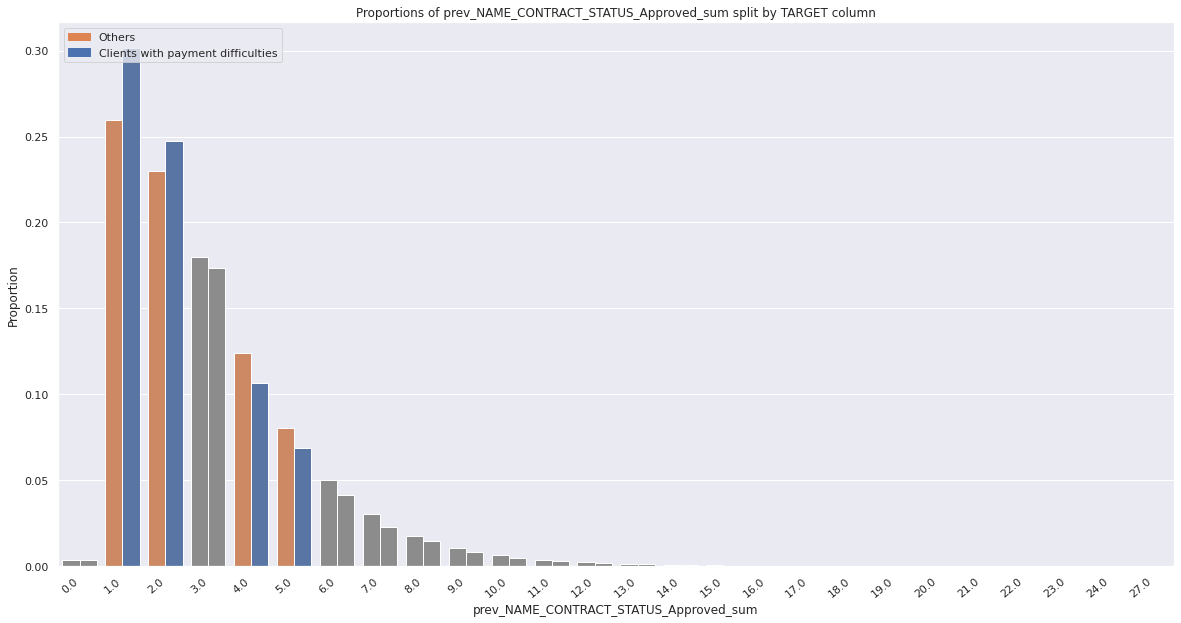

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "prev_NAME_CONTRACT_STATUS_Approved_sum",
    [1, 2, 4, 5],
    [
        "Proportions of prev_NAME_CONTRACT_STATUS_Approved_sum split by TARGET column",
        "prev_NAME_CONTRACT_STATUS_Approved_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

If applicant has more approved loans in the past, the probability of them having payment difficulties decreases.

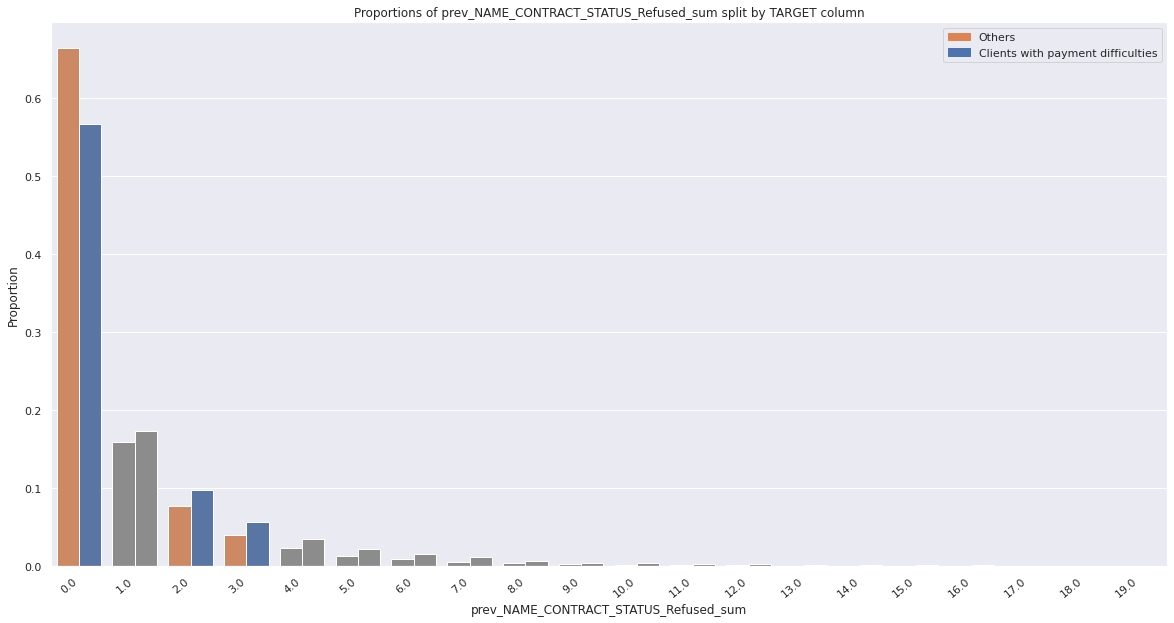

In [ ]:
draw_comparison_barplot(
    df[df["prev_NAME_CONTRACT_STATUS_Refused_sum"] < 20],
    "TARGET",
    "prev_NAME_CONTRACT_STATUS_Refused_sum",
    [0, 2, 3],
    [
        "Proportions of prev_NAME_CONTRACT_STATUS_Refused_sum split by TARGET column",
        "prev_NAME_CONTRACT_STATUS_Refused_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

The opposite is true for rejected loan applications. 

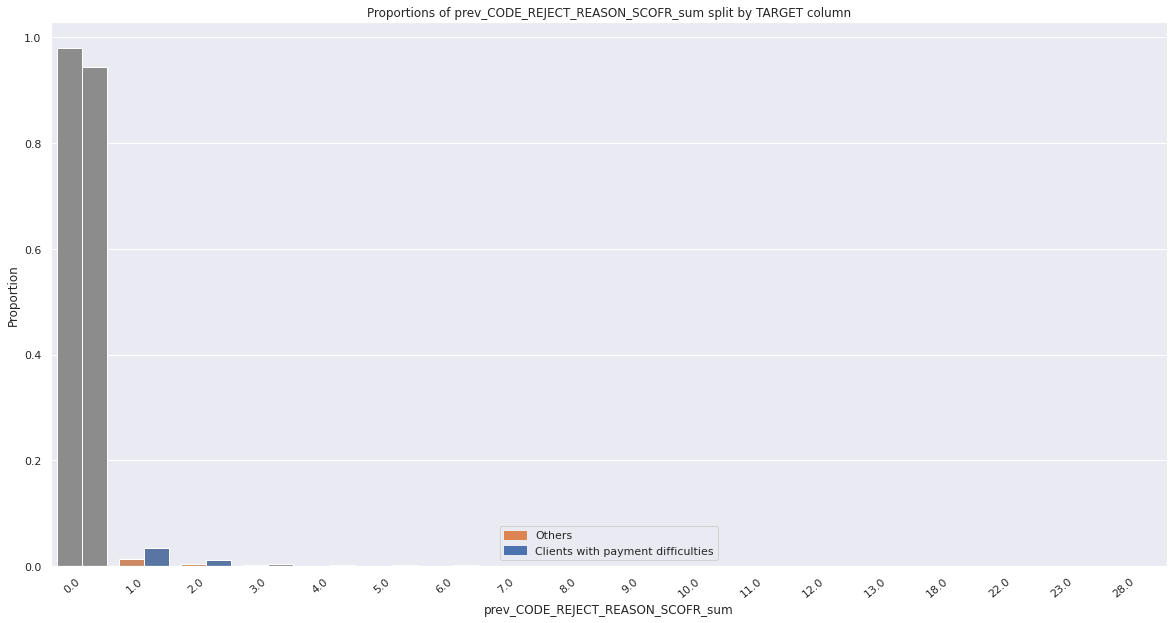

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "prev_CODE_REJECT_REASON_SCOFR_sum",
    [1, 2],
    [
        "Proportions of prev_CODE_REJECT_REASON_SCOFR_sum split by TARGET column",
        "prev_CODE_REJECT_REASON_SCOFR_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

I haven't been able to decode what the abbreviations in the CODE_REJECT_REASON from previous application dataset mean, but it seems that "SCOFR" value especially signifies that the applicant might suffer payment difficulties.

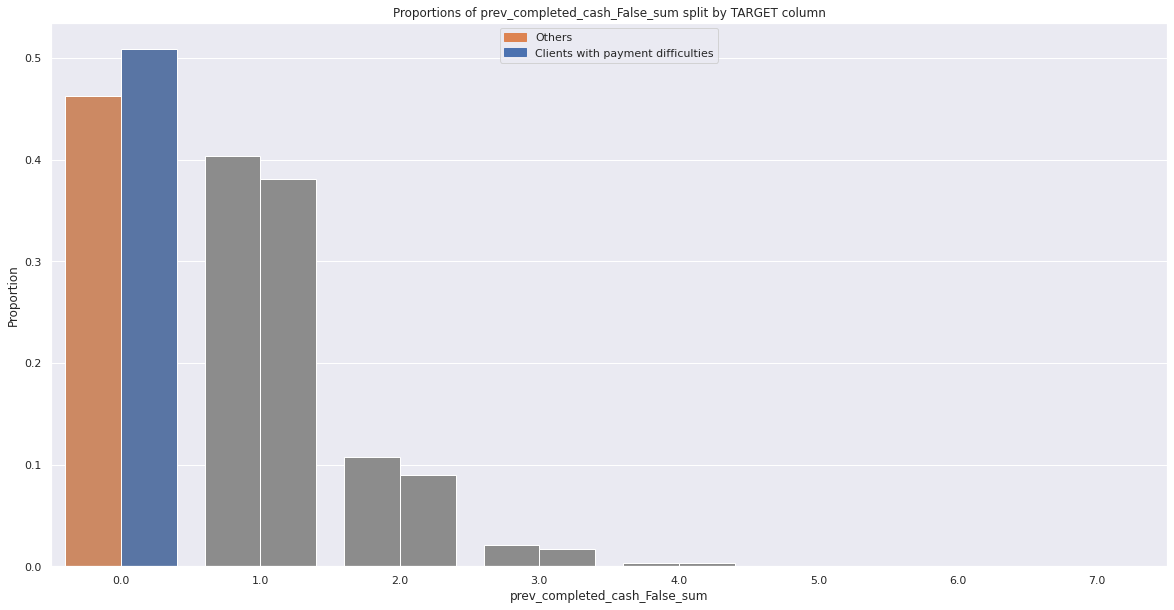

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "prev_completed_cash_False_sum",
    [0],
    [
        "Proportions of prev_completed_cash_False_sum split by TARGET column",
        "prev_completed_cash_False_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

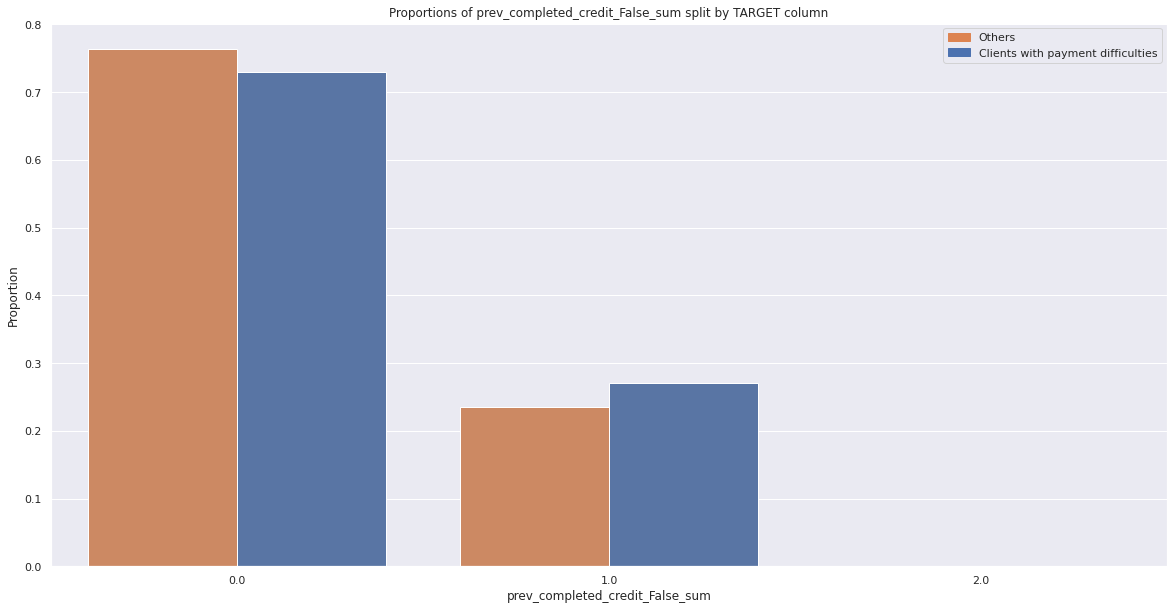

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "prev_completed_credit_False_sum",
    [0, 1],
    [
        "Proportions of prev_completed_credit_False_sum split by TARGET column",
        "prev_completed_credit_False_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

Interesting that, according to this data, if if the client has no active cash loans, that might signify them having payment difficulties, while the opposite is true for credit cards..

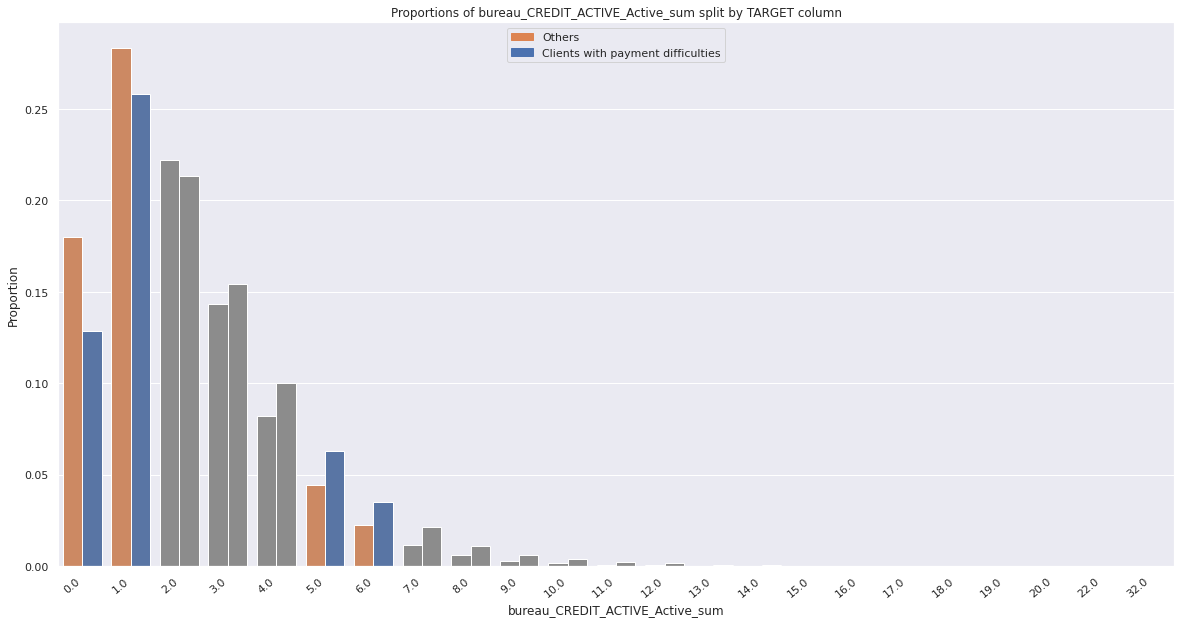

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "bureau_CREDIT_ACTIVE_Active_sum",
    [0, 1, 5, 6],
    [
        "Proportions of bureau_CREDIT_ACTIVE_Active_sum split by TARGET column",
        "bureau_CREDIT_ACTIVE_Active_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
    rotate_x=True,
)

Data from the bureau dataset disagrees with the previous_application dataset - more active loans the applicant have, more likely they will have trouble repaying the current loan.

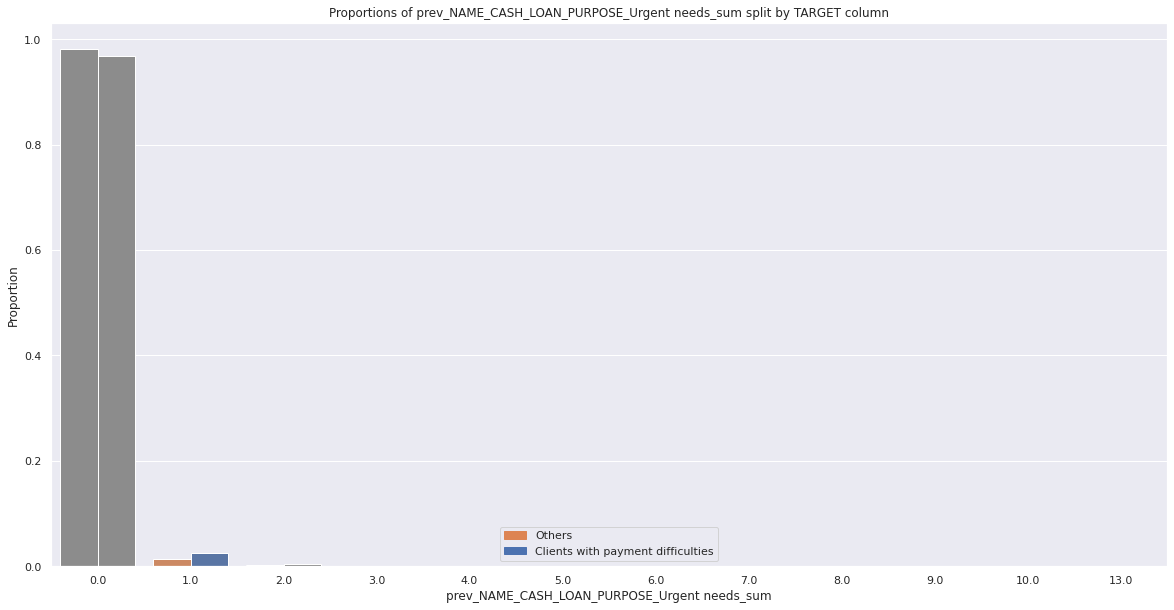

In [ ]:
draw_comparison_barplot(
    df,
    "TARGET",
    "prev_NAME_CASH_LOAN_PURPOSE_Urgent needs_sum",
    [1],
    [
        "Proportions of prev_NAME_CASH_LOAN_PURPOSE_Urgent needs_sum split by TARGET column",
        "prev_NAME_CASH_LOAN_PURPOSE_Urgent needs_sum",
        "Proportion",
        "Others",
        "Clients with payment difficulties",
    ],
    largefig=True,
    mode="proportion",
)

If the applicant has previously taken a loan with the purpose "Urgent needs", it might signify that they'll have trouble repaying the current loan.

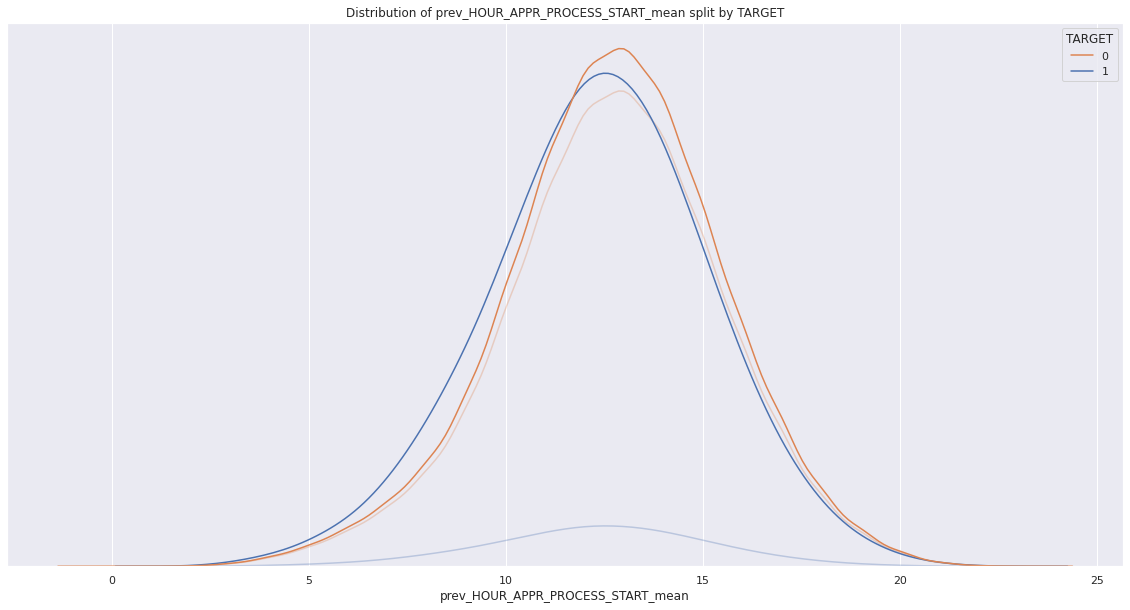

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="prev_HOUR_APPR_PROCESS_START_mean",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df,
    x="prev_HOUR_APPR_PROCESS_START_mean",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="prev_HOUR_APPR_PROCESS_START_mean", ylabel="")
ax.set_title("Distribution of prev_HOUR_APPR_PROCESS_START_mean split by TARGET")
ax.set_yticks([])
plt.show()

Peculiarly, there seem to be slight differences in distribution for the mean hour of past loan process starting, when split by TARGET.

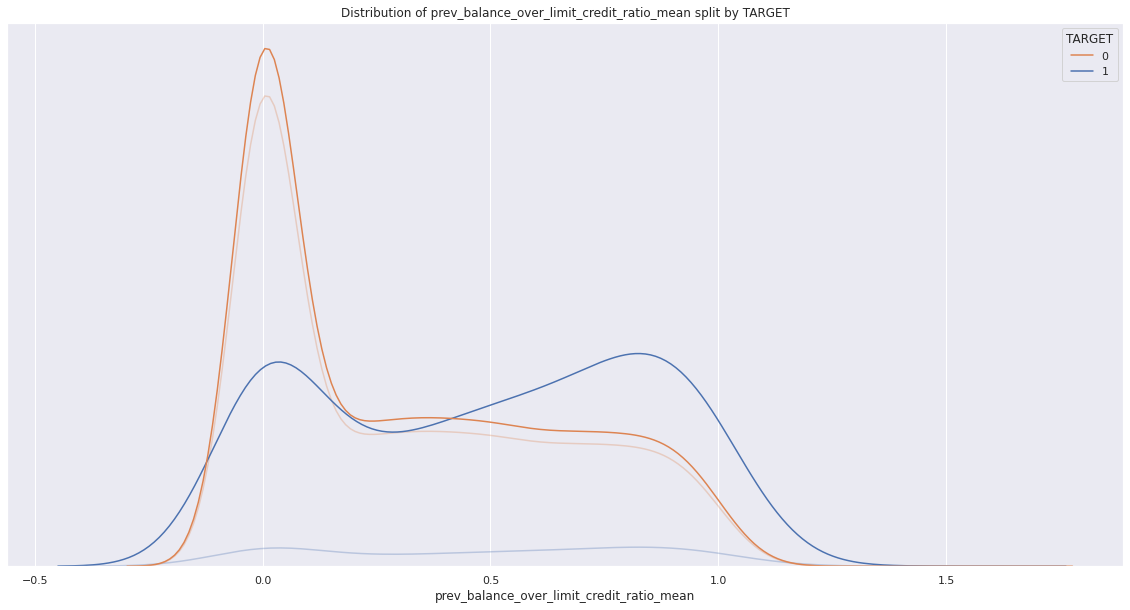

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="prev_balance_over_limit_credit_ratio_mean",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df,
    x="prev_balance_over_limit_credit_ratio_mean",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="prev_balance_over_limit_credit_ratio_mean", ylabel="")
ax.set_title(
    "Distribution of prev_balance_over_limit_credit_ratio_mean split by TARGET"
)
ax.set_yticks([])
plt.show()

A quite large difference can be seen in the distribution of ratio of balance over credit limit for the past credit cards the applicant has taken when split by TARGET

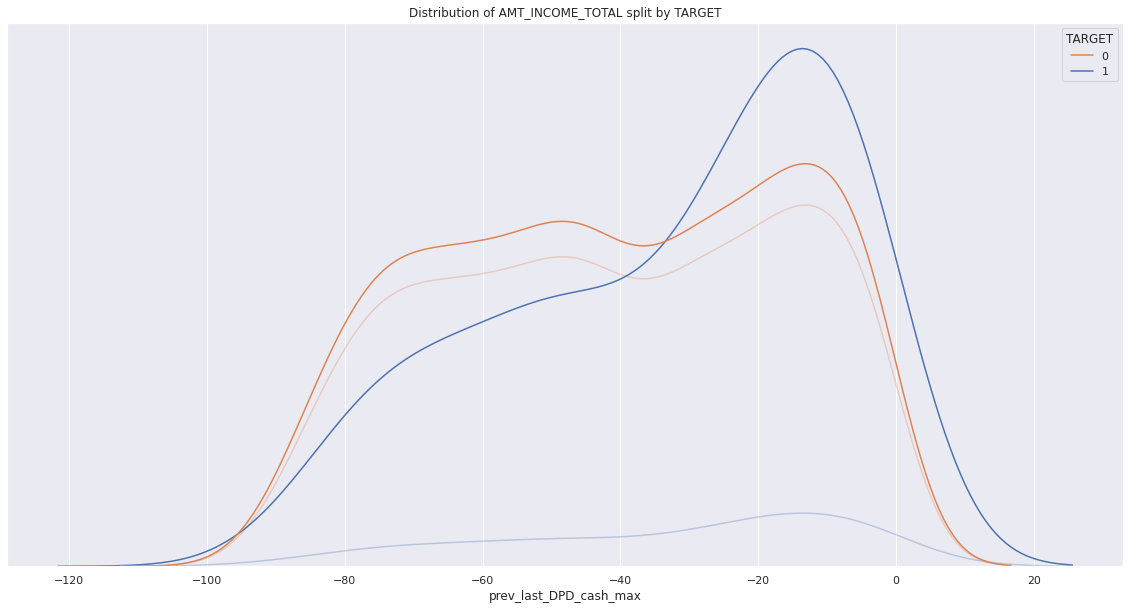

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="prev_last_DPD_cash_max",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    alpha=0.3,
)
ax = sns.kdeplot(
    data=df,
    x="prev_last_DPD_cash_max",
    hue="TARGET",
    palette=[colors["orange"], colors["blue"]],
    bw_adjust=2,
    common_norm=False,
)
ax.set(xlabel="prev_last_DPD_cash_max", ylabel="")
ax.set_title("Distribution of prev_last_DPD_cash_max split by TARGET")
ax.set_yticks([])
plt.show()

And finally we can also see a significant difference between distributions of the last time an applicant has been late on the payment for a past cash loan split by TARGET.

## Data cleaning pt 2

Now that we've taken a closer look at our data, it's time for some cleaning.

In [ ]:
corr_df = df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
corr_df = corr_df.mask(mask)

In [ ]:
corr_df.loc[
    corr_df.index[(corr_df == 1).any(axis=1)], corr_df.columns[(corr_df == 1).any()]
]

,SK_ID_CURR,prev_SK_ID_CURR,prev_NAME_CONTRACT_TYPE_nan_sum,prev_NAME_CONTRACT_STATUS_Unused_offer_sum
prev_SK_ID_CURR,1.000000,NaN,NaN,NaN
prev_CODE_REJECT_REASON_CLIENT_sum,0.000692,0.000692,0.031449,1.000000
prev_PRODUCT_COMBINATION_nan_sum,-0.002504,-0.002504,1.000000,0.031449
bureau_SK_ID_CURR,1.000000,1.000000,-0.003194,0.000944


We have some cases of features having perfect correlation - we will drop one of the columns in each of these cases. Also we will get rid of all of the IDs - we have combined all of the data and have no more use of them.

In [ ]:
df = df.drop(
    [
        "SK_ID_CURR",
        "prev_SK_ID_CURR",
        "bureau_SK_ID_CURR",
        "prev_NAME_CONTRACT_STATUS_Unused_offer_sum",
        "prev_NAME_CONTRACT_TYPE_nan_sum",
    ],
    axis=1,
)

corr_df = corr_df.drop(
    [
        "SK_ID_CURR",
        "prev_SK_ID_CURR",
        "bureau_SK_ID_CURR",
        "prev_NAME_CONTRACT_STATUS_Unused_offer_sum",
        "prev_NAME_CONTRACT_TYPE_nan_sum",
    ],
    axis=1,
)
corr_df = corr_df.drop(
    [
        "SK_ID_CURR",
        "prev_SK_ID_CURR",
        "bureau_SK_ID_CURR",
        "prev_NAME_CONTRACT_STATUS_Unused_offer_sum",
        "prev_NAME_CONTRACT_TYPE_nan_sum",
    ],
    axis=0,
)

In [ ]:
extreme_corr = corr_df.loc[
    corr_df.index[(corr_df > 0.97).any(axis=1)], corr_df.columns[(corr_df > 0.97).any()]
]

extreme_corr[extreme_corr > 0.97]

,AMT_CREDIT,OBS_30_CNT_SOCIAL_CIRCLE,prev_NAME_CONTRACT_TYPE_Cash_loans_sum,prev_NAME_CONTRACT_TYPE_Consumer_loans_sum,prev_NAME_CONTRACT_TYPE_Revolving_loans_sum,prev_NAME_CONTRACT_STATUS_Canceled_sum,prev_NAME_PORTFOLIO_nan_sum,prev_AMT_APPLICATION_mean
AMT_GOODS_PRICE,0.986968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OBS_60_CNT_SOCIAL_CIRCLE,NaN,0.99849,NaN,NaN,NaN,NaN,NaN,NaN
prev_NAME_CASH_LOAN_PURPOSE_nan_sum,NaN,NaN,0.97583,NaN,NaN,NaN,NaN,NaN
prev_CODE_REJECT_REASON_nan_sum,NaN,NaN,NaN,NaN,NaN,0.99608,NaN,NaN
prev_NAME_GOODS_CATEGORY_nan_sum,NaN,NaN,NaN,NaN,0.972275,NaN,NaN,NaN
prev_NAME_PORTFOLIO_POS_sum,NaN,NaN,NaN,0.973365,NaN,NaN,NaN,NaN
prev_NAME_PRODUCT_TYPE_nan_sum,NaN,NaN,NaN,NaN,NaN,NaN,0.973916,NaN
prev_AMT_CREDIT_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975854


We still have some cases of extreme if not perfect correlation.

In [ ]:
(corr_df > 0.7).sum().sum()

128

We'll want to drop columns that are too closely correlated to each other to avoid multicollinearity. There are still 128 cases of correlation higher than 0.7 in our dataset.

In [ ]:
np.isinf(df.loc[:, df.columns[~(df.dtypes == "object")]]).sum().sort_values(
    ascending=False
).head()

prev_amount_per_drawing_credit_mean_mean      322
prev_balance_over_limit_credit_ratio_mean     132
TARGET                                          0
prev_NAME_SELLER_INDUSTRY_Clothing_sum          0
prev_NAME_SELLER_INDUSTRY_Construction_sum      0
dtype: int64

In [ ]:
for column in df.columns[~(df.dtypes == "object")][
    np.isinf(df.loc[:, df.columns[~(df.dtypes == "object")]]).any()
]:
    df.loc[np.isinf(df[column]), column] = np.nan

We can see that there are some columns containing "infinity" values - we will convert them to np.nan for now.

Now let's see what we can do about the missing data in the new columns.

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(20)

prev_last_DPD_credit_max                         95.909740
bureau_last_DPD_months_max                       89.902150
prev_last_DPD_cash_max                           83.271818
prev_amount_per_drawing_credit_mean_mean         82.930692
prev_atm_drawings_vs_all_drawings_credit_mean    82.826631
prev_balance_over_limit_credit_ratio_mean        74.942360
prev_all_drawings_credit_sum_mean                74.656516
COMMONAREA_MODE                                  69.872297
NONLIVINGAPARTMENTS_MODE                         69.432963
FONDKAPREMONT_MODE                               68.386172
LIVINGAPARTMENTS_MODE                            68.354953
FLOORSMIN_MODE                                   67.848630
YEARS_BUILD_MODE                                 66.497784
OWN_CAR_AGE                                      65.990810
LANDAREA_MODE                                    59.376738
BASEMENTAREA_MODE                                58.515956
EXT_SOURCE_1                                     56.3810

The three features with the highest count of missing data are all columns containing "months since last dpd" data. Since missing data in these cases signify that the applicant either hasn't ever been late on payments for the type of the loan or hasn't ever even taken the type of the loan, the missing data here isn't a mystery. We will deal with it by imputing the missing values with the largest available value in the column multiplied by 2 - if it's better for the applicant to have been late on payment for a loan in a less recent history, it's even more better to have never been late on payments at all.

In [ ]:
df.loc[
    :,
    [
        "prev_last_DPD_credit_max",
        "bureau_last_DPD_months_max",
        "prev_last_DPD_cash_max",
        "prev_DAYS_DECISION_max",
    ],
].min() * 2

prev_last_DPD_credit_max      -190.0
bureau_last_DPD_months_max    -186.0
prev_last_DPD_cash_max        -190.0
prev_DAYS_DECISION_max       -5844.0
dtype: float64

In [ ]:
for column in [
    "prev_last_DPD_credit_max",
    "bureau_last_DPD_months_max",
    "prev_last_DPD_cash_max",
    "prev_DAYS_DECISION_max",
]:
    df[column] = df[column].fillna(df[column].min() * 2)

In [ ]:
(df.isna().sum() * 100 / df.shape[0]).sort_values(ascending=False).head(20)

prev_amount_per_drawing_credit_mean_mean         82.930692
prev_atm_drawings_vs_all_drawings_credit_mean    82.826631
prev_balance_over_limit_credit_ratio_mean        74.942360
prev_all_drawings_credit_sum_mean                74.656516
COMMONAREA_MODE                                  69.872297
NONLIVINGAPARTMENTS_MODE                         69.432963
FONDKAPREMONT_MODE                               68.386172
LIVINGAPARTMENTS_MODE                            68.354953
FLOORSMIN_MODE                                   67.848630
YEARS_BUILD_MODE                                 66.497784
OWN_CAR_AGE                                      65.990810
LANDAREA_MODE                                    59.376738
BASEMENTAREA_MODE                                58.515956
EXT_SOURCE_1                                     56.381073
NONLIVINGAREA_MODE                               55.179164
ELEVATORS_MODE                                   53.295980
WALLSMATERIAL_MODE                               50.8407

Let's take a closer look at the next 4 columns with most missing values.

In [ ]:
credit_na_columns = [
    "prev_atm_drawings_vs_all_drawings_credit_mean",
    "prev_balance_over_limit_credit_ratio_mean",
    "prev_amount_per_drawing_credit_mean_mean",
    "prev_all_drawings_credit_sum_mean",
]

df.loc[:, ["prev_NAME_CONTRACT_TYPE_Revolving_loans_sum"] + credit_na_columns].head(10)

,prev_NAME_CONTRACT_TYPE_Revolving_loans_sum,prev_atm_drawings_vs_all_drawings_credit_mean,prev_balance_over_limit_credit_ratio_mean,prev_amount_per_drawing_credit_mean_mean,prev_all_drawings_credit_sum_mean
0,0.0,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN
3,2.0,NaN,0.000000,NaN,0.0
4,0.0,NaN,NaN,NaN,NaN
5,0.0,NaN,NaN,NaN,NaN
6,0.0,NaN,NaN,NaN,NaN
7,0.0,NaN,NaN,NaN,NaN
8,1.0,1.0,0.331825,45000.0,180000.0
9,0.0,NaN,NaN,NaN,NaN


We can see that all 4 of the columns describe credit card loans and the missing data can be found for clients that haven't taken any credit card loans. In cases where the applicants have taken credit cards, some of the columns might have missing data in cases where the client hasn't drawn any money.

We will impute these values with 0

In [ ]:
df.loc[:, credit_na_columns] = df.loc[:, credit_na_columns].fillna(0)

In [ ]:
(
    df.loc[:, df.columns[df.columns.str.contains("prev_")]].isna().sum()
    * 100
    / df.shape[0]
).value_counts()

5.350703     107
0.000000       7
11.025947      2
5.486308       1
5.667765       1
9.732010       1
5.485657       1
dtype: int64

In [ ]:
(
    df.loc[
        df["prev_NAME_CONTRACT_TYPE_Cash_loans_sum"].isna(),
        df.columns[df.columns.str.contains("prev_")],
    ]
    .isna()
    .sum()
    * 100
    / df["prev_NAME_CONTRACT_TYPE_Cash_loans_sum"].isna().sum()
).value_counts()

100.0    113
0.0        7
dtype: int64

Looking at the other features from the previous application dataset we can see that for 5.35 % of the entries they all are missing (except for the 7 features for whom we already imputed the missing values). This probably means, that these 5 % of the clients are new and have no past loans. We will fill all the values for these rows with 0.

In [ ]:
df.loc[
    df["prev_NAME_CONTRACT_TYPE_Cash_loans_sum"].isna(),
    df.columns[df.columns.str.contains("prev_")],
] = df.loc[
    df["prev_NAME_CONTRACT_TYPE_Cash_loans_sum"].isna(),
    df.columns[df.columns.str.contains("prev_")],
].fillna(
    0
)

In [ ]:
(
    df.loc[:, df.columns[df.columns.str.contains("bureau_")]].isna().sum()
    * 100
    / df.shape[0]
).value_counts()

14.314935    15
0.000000      1
dtype: int64

In [ ]:
(
    df.loc[
        df["bureau_CREDIT_ACTIVE_Closed_sum"].isna(),
        df.columns[df.columns.str.contains("bureau_")],
    ]
    .isna()
    .sum()
    * 100
    / df["bureau_CREDIT_ACTIVE_Closed_sum"].isna().sum()
).value_counts()

100.0    15
0.0       1
dtype: int64

We can see the same situation with missing data for features from bureau dataset. We will also fill these values with 0.

In [ ]:
df.loc[
    df["bureau_CREDIT_ACTIVE_Closed_sum"].isna(),
    df.columns[df.columns.str.contains("bureau_")],
] = df.loc[
    df["bureau_CREDIT_ACTIVE_Closed_sum"].isna(),
    df.columns[df.columns.str.contains("bureau_")],
].fillna(
    0
)

We will deal with the rest of the missing values using the transformer we previously made.

We will also do a little bit of data engineering. I didn't see many obvious candidates for it, but thought that taking the ratio of credit amount over annual income might be relevant, as could be the ratio of credit amount over mean past loan credit amount.

In [ ]:
df["annual_income_vs_credit"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df["previous_credit_vs_current"] = df["AMT_CREDIT"] / df["prev_AMT_CREDIT_mean"]

for column in df.columns[~(df.dtypes == "object")][
    np.isinf(df.loc[:, df.columns[~(df.dtypes == "object")]]).any()
]:
    df.loc[np.isinf(df[column]), column] = np.nan

## Modelling using all data

Let's see whether adding all the additional data will lead to a better model!

In [ ]:
df2 = df.copy()
df = df2.sample(frac=0.5, random_state=42)

In [ ]:
train_set, test_set, train_target, test_target = train_test_split(
    df.loc[:, df.columns[df.columns != "TARGET"]],
    df["TARGET"],
    test_size=0.2,
    random_state=42,
    stratify=df["TARGET"],
)

In [ ]:
drop_cols = columns_to_drop_due_multicoll(train_set.join(train_target))
best_corrs_means_dict, max_corr_pair_dict = get_best_corrs_missing_cols(
    train_set, drop_cols
)
one_hot_columns = df.columns[df.dtypes == "object"]
missing_dict = {"ORGANIZATION_TYPE": "XNA", "DAYS_EMPLOYED": 365243}

In [ ]:
OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)

Preprocessor = Pipeline(
    [
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "values_to_other",
            SmallValuesToOther(one_hot_columns[df[one_hot_columns].nunique() > 3]),
        ),
        (
            "fill_missing_data",
            FillMissingDataCurrentOnly(
                best_corrs_means_dict, max_corr_pair_dict, drop_cols, fillna=True
            ),
        ),
        ("one_hot_encode", OneHotPipeline),
    ]
)

In [ ]:
temp_df = Preprocessor.fit_transform(train_set)
temp_df_test = Preprocessor.transform(test_set)

We'll go straight to training with optuna.

In [ ]:
def objective_booster_class_imb(trial, X: pd.DataFrame, y: pd.Series):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.7)
    n_estimators = trial.suggest_int("n_estimators", 10, 250)
    max_depth = trial.suggest_int("max_depth", 2, 5, log=True)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 1e-10, 0.1)
    scale_pos_weight = trial.suggest_int("scale_pos_weight", 5, 9)
    num_boost_round = trial.suggest_int("num_boost_round", 60, 110)

    skf = StratifiedKFold(n_splits=3)

    score = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_xg_DMatrix = xg.DMatrix(data=X_train, label=y_train)
        test_xg_DMatrix = xg.DMatrix(data=X_test, label=y_test)

        params = {
            "learning_rate": learning_rate,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_impurity_decrease": min_impurity_decrease,
            "scale_pos_weight": scale_pos_weight,
            "booster": "gbtree",
        }

        model = xg.train(
            params, train_xg_DMatrix, feval="aucpr", num_boost_round=num_boost_round
        )
        result = np.round(model.predict(test_xg_DMatrix))
        score.append(average_precision_score(y_test, result))

    print(score)

    pr_auc = pd.Series(score).mean()
    return pr_auc

In [ ]:
grade_wrapper = lambda trial: objective_booster_class_imb(trial, temp_df, train_target)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=40)

The best value we got is 0.1531. Not great but more than a percent increase from the model using just the current loan data. 

Let's see how well the model will work on the test data

In [ ]:
train_xg_DMatrix = xg.DMatrix(data=temp_df, label=train_target)
test_xg_DMatrix = xg.DMatrix(data=temp_df_test, label=test_target)

In [ ]:
params = {
    "learning_rate": 0.20687175214986742,
    "n_estimators": 68,
    "max_depth": 3,
    "min_impurity_decrease": 0.08129404748664394,
    "scale_pos_weight": 7,
    "booster": "gbtree",
}

model = xg.train(params, train_xg_DMatrix, feval="aucpr", num_boost_round=91)
result = np.round(model.predict(test_xg_DMatrix))

In [ ]:
average_precision_score(test_target, result)

0.14763809015552892

In [ ]:
roc_auc_score(test_target, result)

0.6645246209737525

Slightly worse than on the training data.

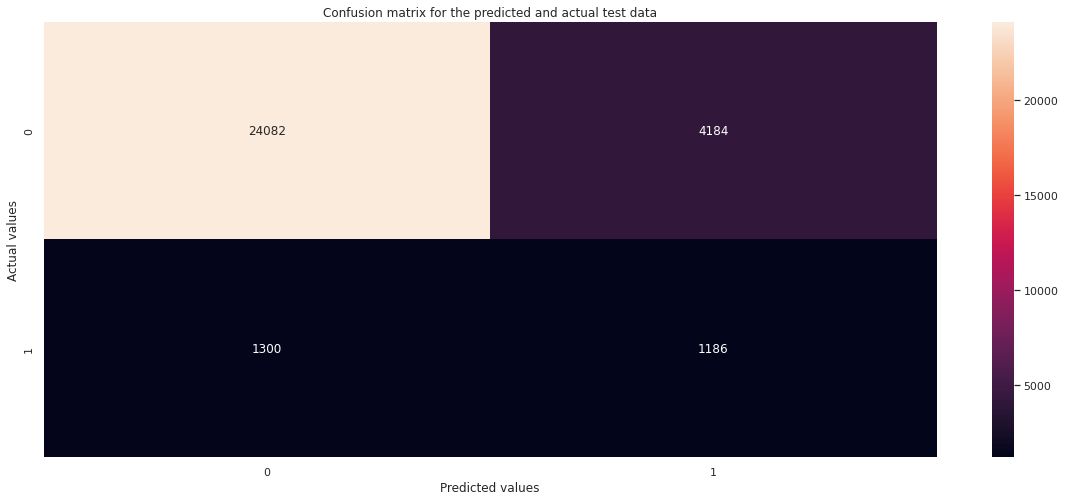

In [ ]:
matrix = confusion_matrix(test_target, result)
label_list = ["0", "1"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

We can see that the model correctly has predicted 6/7 of the negative values, while less than half of the positive values have been predicted correctly.

Let's train the model on the whole dataset now!

In [ ]:
df = df2.copy()

In [ ]:
train_set, test_set, train_target, test_target = train_test_split(
    df.loc[:, df.columns[df.columns != "TARGET"]],
    df["TARGET"],
    test_size=0.2,
    random_state=42,
    stratify=df["TARGET"],
)

In [ ]:
drop_cols = columns_to_drop_due_multicoll(train_set.join(train_target))
best_corrs_means_dict, max_corr_pair_dict = get_best_corrs_missing_cols(
    train_set, drop_cols
)
one_hot_columns = df.columns[df.dtypes == "object"]
missing_dict = {"ORGANIZATION_TYPE": "XNA", "DAYS_EMPLOYED": 365243}

In [ ]:
OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)

Preprocessor = Pipeline(
    [
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "values_to_other",
            SmallValuesToOther(one_hot_columns[df[one_hot_columns].nunique() > 3]),
        ),
        (
            "fill_missing_data",
            FillMissingDataCurrentOnly(
                best_corrs_means_dict, max_corr_pair_dict, drop_cols, fillna=True
            ),
        ),
        ("one_hot_encode", OneHotPipeline),
    ]
)

In [ ]:
temp_df = Preprocessor.fit_transform(train_set)
temp_df_test = Preprocessor.transform(test_set)

In [ ]:
joblib.dump(Preprocessor, "Preprocessor.pkl")

['Preprocessor.pkl']

Before we predict the test data let's check whether tweaking the threshold a bit could improve the model.

In [ ]:
train_set_val, test_set_val, train_target_val, test_target_val = train_test_split(
    temp_df, train_target, test_size=0.2, random_state=42, stratify=train_target
)

In [ ]:
train_xg_DMatrix = xg.DMatrix(data=train_set_val, label=train_target_val)
test_xg_DMatrix = xg.DMatrix(data=test_set_val, label=test_target_val)

In [ ]:
params = {
    "learning_rate": 0.20687175214986742,
    "n_estimators": 68,
    "max_depth": 3,
    "min_impurity_decrease": 0.08129404748664394,
    "scale_pos_weight": 7,
    "booster": "gbtree",
}

model = xg.train(params, train_xg_DMatrix, num_boost_round=91)
result = np.round(model.predict(test_xg_DMatrix))

In [ ]:
average_precision_score(test_target_val, result)

0.15161131317817972

In [ ]:
roc_auc_score(test_target_val, result)

0.6737242724274431

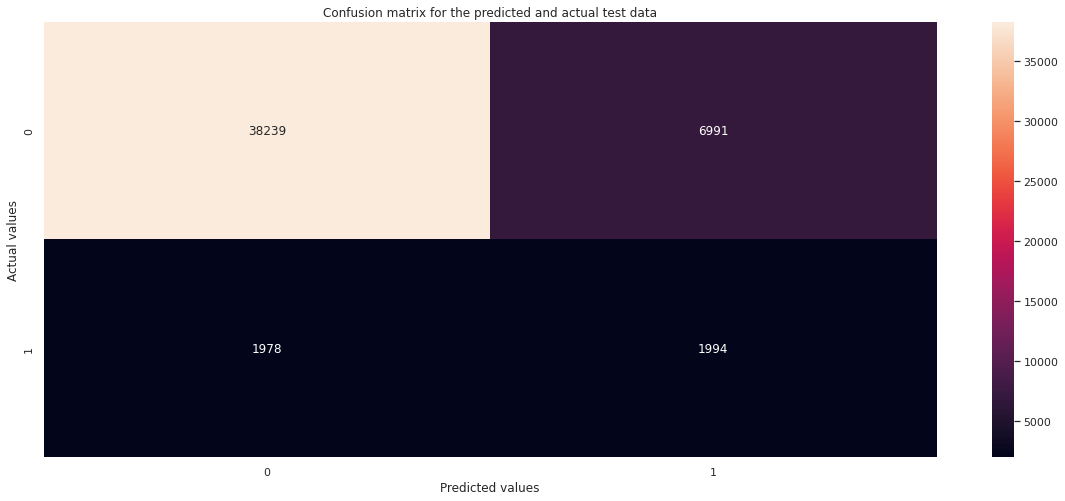

In [ ]:
matrix = confusion_matrix(test_target_val, result)
label_list = ["0", "1"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

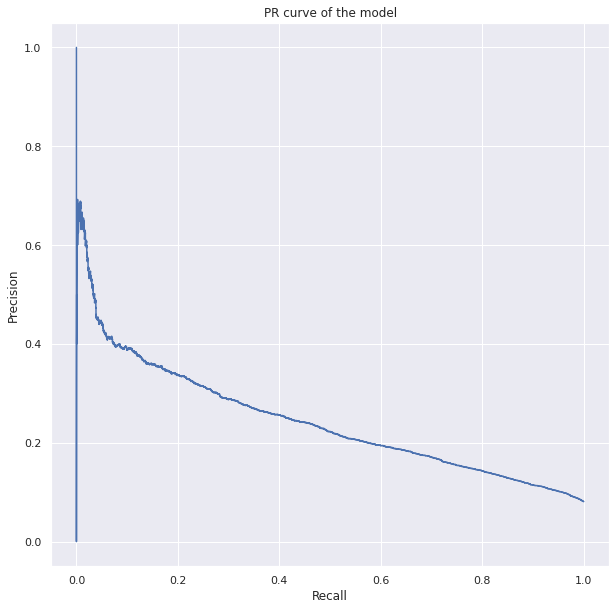

In [ ]:
precision, recall, thresholds = precision_recall_curve(
    test_target_val, model.predict(test_xg_DMatrix)
)

plt.figure(figsize=(10, 10))
plt.plot(recall, precision, linestyle="-")
plt.title(
    "PR curve of the model"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

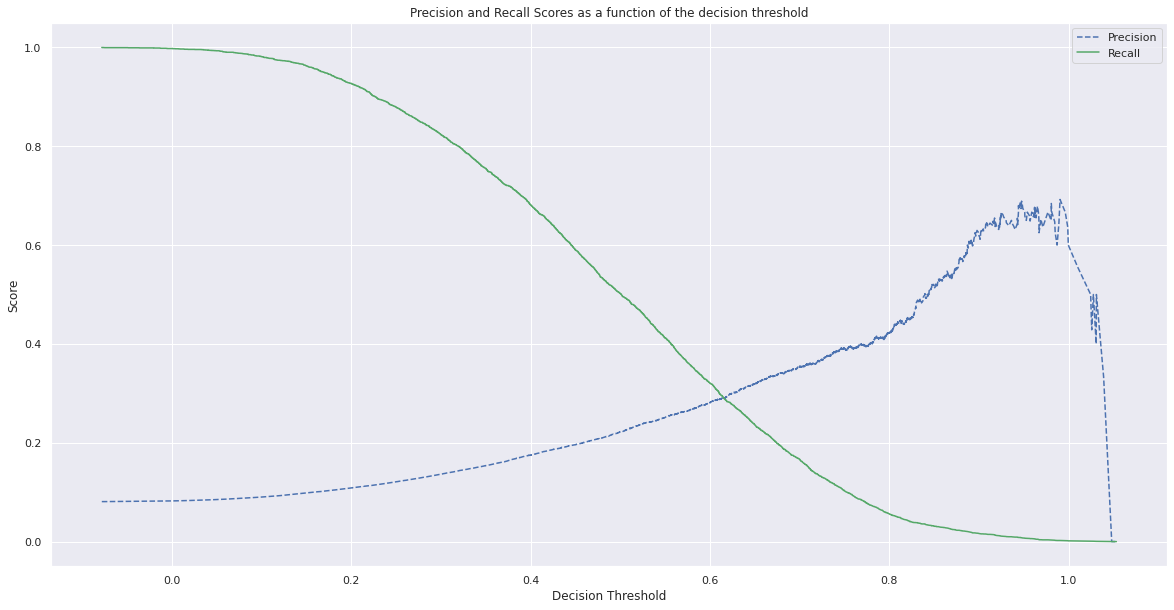

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc="best")
plt.show()

We are more interested in recall - predicting correctly the minority target value. Since that is the case, it might make sense to move the threshold to 0.4 - increase recall by a lot, while only losing a little precision.

In [ ]:
result = model.predict(test_xg_DMatrix) > 0.4

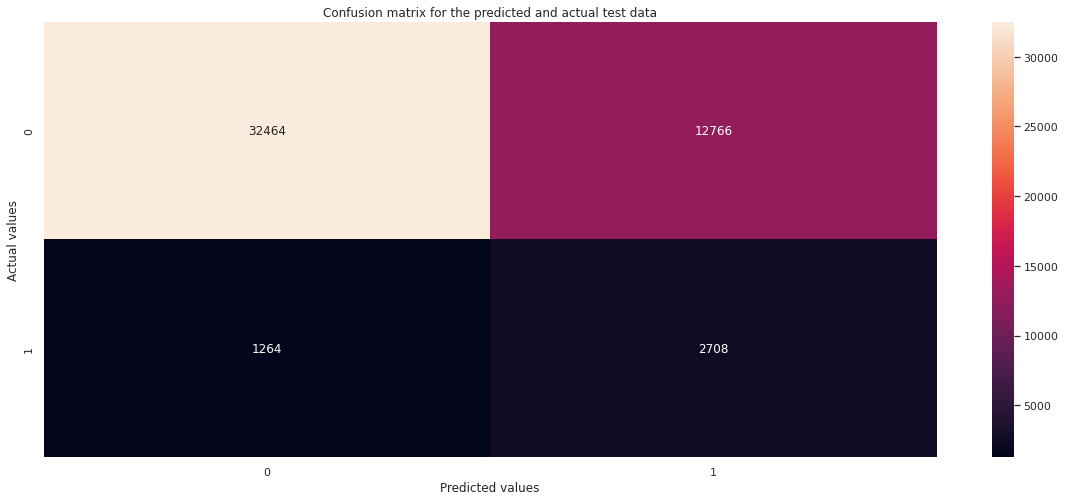

In [ ]:
matrix = confusion_matrix(test_target_val, result)
label_list = ["0", "1"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

While the amount of false positives seems scary, this model actually seems more useful - more than two thirds of both positive and negative values have been predicted correctly. We might actually want to move the threshold even more - while the resulting model would not be too good to predict positive values, we could be quite certain that the negative values really are negative which might have some usage.

In [ ]:
train_xg_DMatrix = xg.DMatrix(data=temp_df, label=train_target)
test_xg_DMatrix = xg.DMatrix(data=temp_df_test, label=test_target)

In [ ]:
params = {
    "learning_rate": 0.20687175214986742,
    "n_estimators": 68,
    "max_depth": 3,
    "min_impurity_decrease": 0.08129404748664394,
    "scale_pos_weight": 7,
    "booster": "gbtree",
}
model = xg.train(params, train_xg_DMatrix, feval="aucpr", num_boost_round=91)
result = model.predict(test_xg_DMatrix) > 0.3

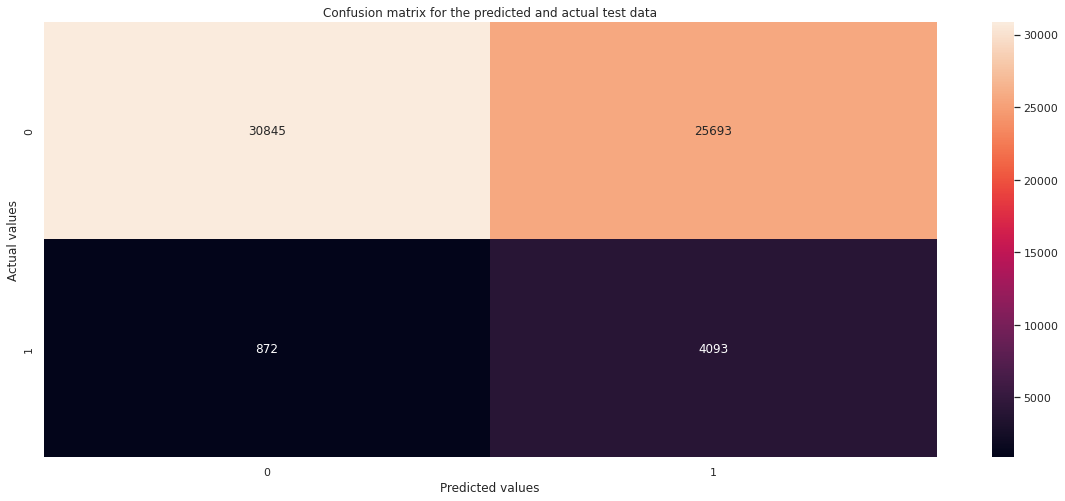

In [ ]:
matrix = confusion_matrix(test_target, result)
label_list = ["0", "1"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

After moving the threshold even more, we get a model that has only a small amount of false negatives, while correctly predicting more than a half of the negative values.

In [ ]:
joblib.dump(model, "model.pkl")

['model.pkl']

## Conclusions

In modern culture the two most used "fix-everything-without-explanation" tropes are nanotechnology and AI. You just plug it in and it solves all your problems. In real world, however, such magical solutions are harder to come by and you have to be ready to adjust your goals and expectations. The model we've trained is not good enough to automate the loan issuing decision, completely bypassing human input. However, the model could be used for different purposes - for example, in case the company has limited resources and can invest in only the safest options, the model with extremely low thresholds will predict the negative cases quite accurately. Another use case could be if the company wants to monitor closely their investments, but don't have the resources to monitor all of their clients, the model can be used to filter out the most unreliable cases - with threshold 0.5, model accurately predicted half of the positive cases, while incorrectly predicting only 1/7 of the negative cases. Also the threshold could be adjusted as the company gains more resources.

## What could be improved


*   Try tuning other models besides xgboost. I checked some others - random forest and logistic regression and they performed worse than the xgboost, but I didn't try tuning them.
*   Reduce the amount of features (and thus time taken by feature cleaning) to speed up live predictions
*   Combine the seperate data cleaning elements into custom transformers and pipelines.

